<a href="https://colab.research.google.com/github/Salimovsky/StockML/blob/master/Microsoft_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Microsoft stock price prediction

<table class="tfo-notebook-buttons" align="left">

  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1F8Dxp97s91mtbj8ipbcgZCZhb6k34bVY#scrollTo=pa49bUnKyRgF"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Salimovsky/StockML/blob/master/Microsoft_stock_price_prediction.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This an initial attempt to predict stock market movement of a specific stock by using time series prediction using Recurrent Neural Networks (RNNs). This is covered in two parts: first, we will forecast a univariate time series, then we will forecast a multivariate time series.

In [1]:
## Install TA library module:
def install_TA_Lib():
  # use this if running on dedicated server machine (ex: JupiterLab)
  # !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  # !tar -xzvf ta-lib-0.4.0-src.tar.gz
  # %cd ta-lib
  # !./configure --prefix=/usr
  # !make
  # !make install
  # !pip install Ta-Lib

  # OR install TA lib binary, in case running on Colab (no dedicated server machine)
  # !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
  # !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
  # !dpkg -i libta.deb ta.deb
  # !pip install Ta-Lib
  print("Uncomment this code to install TA-Lib first time you run this script!")

install_TA_Lib()

Uncomment this code to install TA-Lib first time you run this script!


In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import talib
from tensorflow.python.keras.initializers import RandomUniform

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

## Microsoft stock dataset
This project uses data from <a href="https://polygon.io/" class="external">Polygon Financial data platform</a> fetched using a kotlin client program of Polygon Rest API <a href="https://polygon.io/docs/#get_v2_aggs_ticker__ticker__range__multiplier___timespan___from___to__anchor" class="external"></a>.

This dataset contains 33 different features such as price, volume, time, moving average, and OCHL. These were aggregates of trades for every 1 minute, beginning in 2019/01/01. This dataset was prepared by me for the purpose of this project.

MSFT timestampMs, 
MSFT monthOfYear, 
MSFT dayOfMonth, 
MSFT dayOfWeek, 
MSFT hourOfDay, 
MSFT minuteOfHour, 
MSFT volume, 
MSFT weightedPrice, 
MSFT open, 
MSFT high, 
MSFT low, 
MSFT close, 
MSFT Days Avg 3 Low, 
MSFT Days Avg 3 Weighted, 
MSFT Days Avg 3 High, 
MSFT Days Avg 5 Low, 
MSFT Days Avg 5 Weighted, 
MSFT Days Avg 5 High, 
MSFT Days Avg 10 Low, 
MSFT Days Avg 10 Weighted, 
MSFT Days Avg 10 High, 
MSFT Days Avg 20 Low, 
MSFT Days Avg 20 Weighted, 
MSFT Days Avg 20 High, 
MSFT Days Avg 50 Low, 
MSFT Days Avg 50 Weighted, 
MSFT Days Avg 50 High, 
MSFT Days Avg 100 Low, 
MSFT Days Avg 100 Weighted, 
MSFT Days Avg 100 High, 
MSFT Days Avg 200 Low, 
MSFT Days Avg 200 Weighted, 
MSFT Days Avg 200 High, 

In [3]:
# The raw dat file is located in my personal google drive, and is shared to the public. Please email me at salim.addi@gmail.com if You can't download the file anymore!
# uncomment this line to remove cached file if you need to reload an updated version of raw data file
#!rm ~/.keras/datasets/MSFT.csv
file_path = tf.keras.utils.get_file(
    origin='https://docs.google.com/uc?export=download&id=14Y3yvzY8CEIIg-C4vX4HsSwJxGU3sx7B',
    fname='MSFT.csv',
    extract=False)
df = pd.read_csv(file_path, sep='|')

Let's take a glance at the data.

In [4]:
df.head()

,MSFT timestampMs,MSFT monthOfYear,MSFT dayOfMonth,MSFT dayOfWeek,MSFT hourOfDay,MSFT minuteOfHour,MSFT volume,MSFT weightedPrice,MSFT open,MSFT high,...,MSFT Days Avg 20 High,MSFT Days Avg 50 Low,MSFT Days Avg 50 Weighted,MSFT Days Avg 50 High,MSFT Days Avg 100 Low,MSFT Days Avg 100 Weighted,MSFT Days Avg 100 High,MSFT Days Avg 200 Low,MSFT Days Avg 200 Weighted,MSFT Days Avg 200 High
0,1546419600000,1,2,4,3,0,387.0,99.4000,99.40,99.40,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
1,1546419840000,1,2,4,3,4,371.0,98.9013,98.88,98.88,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
2,1546420320000,1,2,4,3,12,100.0,99.2000,99.20,99.20,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
3,1546420500000,1,2,4,3,15,380.0,99.2000,99.20,99.20,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
4,1546420980000,1,2,4,3,23,188.0,99.2330,99.20,99.20,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615


The original dataset contains 32 features. And we added more features by extracting technical analysis indicators from OCHL data.

In [5]:
from talib import MA_Type

## Technical Analysis Indicators
ta_weighted_price = 'MSFT weightedPrice'
ta_volume = 'MSFT volume'
ta_time_stamp = 'MSFT timestampMs'
ta_obv = 'MSFT OBV'
ta_price_change_class = 'MSFT price change class'
ta_price_change_class_sign = 'MSFT price change class sign'
ta_price_change = 'MSFT price change'
ta_log_return = 'MSFT log return'


wighted_prices = df[ta_weighted_price]
open = df['MSFT open']
high = df['MSFT high']
low = df['MSFT low']
close = df['MSFT close']
volume = df[ta_volume]

price_SMA_50 = talib.SMA(wighted_prices.values, timeperiod=50)
price_SMA_100 = talib.SMA(wighted_prices.values, timeperiod=100)
price_SMA_200 = talib.SMA(wighted_prices.values, timeperiod=200)
price_DEMA_5 = talib.DEMA(wighted_prices.values, timeperiod=5)
price_DEMA_10 = talib.DEMA(wighted_prices.values, timeperiod=10)
price_DEMA_20 = talib.DEMA(wighted_prices.values, timeperiod=20)
bbands_20 = talib.BBANDS(wighted_prices.values, timeperiod=20, matype=MA_Type.T3)
bbands_10 = talib.BBANDS(wighted_prices.values, timeperiod=10, matype=MA_Type.T3)
rsi_14 = talib.RSI(wighted_prices.values, timeperiod=14)
stoch_14 = talib.STOCH(high.values, low.values, wighted_prices.values, fastk_period=14)
obv = talib.OBV(wighted_prices.values, volume)
macd = talib.MACD(wighted_prices.values, fastperiod=12, slowperiod=26, signalperiod=9)

df['MSFT SMA 50'] = price_SMA_50
df['MSFT SMA 100'] = price_SMA_100
df['MSFT SMA 200'] = price_SMA_200
df['MSFT DEMA 5'] = price_DEMA_5
df['MSFT DEMA 10'] = price_DEMA_10
df['MSFT DEMA 20'] = price_DEMA_20
df['MSFT BBANDS 20 UPPER'], df['MSFT BBANDS 20 MIDDLE'], df['MSFT BBANDS 20 LOWER'] = bbands_20
df['MSFT BBANDS 10 UPPER'], df['MSFT BBANDS 10 MIDDLE'], df['MSFT BBANDS 10 LOWER'] = bbands_10
df['MSFT RSI 14'] = rsi_14
df['MSFT STOCH 14 lowk'], df['MSFT STOCH 14 lowd'] = stoch_14
df[ta_obv] = obv
df['MSFT macd'], df['MSFT macdsignal'], df['MSFT macdhist']= macd

## Pattern recognition
two_crows = talib.CDL2CROWS(open.values, high.values, low.values, close.values)
three_black_crows = talib.CDL3BLACKCROWS(open.values, high.values, low.values, close.values)
hammer = talib.CDLHAMMER(open.values, high.values, low.values, close.values)
inverse_hammer = talib.CDLINVERTEDHAMMER(open.values, high.values, low.values, close.values)
engulfing = talib.CDLENGULFING(open.values, high.values, low.values, close.values)
piercing = talib.CDLPIERCING(open.values, high.values, low.values, close.values)
morning_star = talib.CDLMORNINGSTAR(open.values, high.values, low.values, close.values, penetration=0)
three_white_soldiers = talib.CDL3WHITESOLDIERS(open.values, high.values, low.values, close.values)
hanging_man = talib.CDLHANGINGMAN(open.values, high.values, low.values, close.values)
shooting_star = talib.CDLSHOOTINGSTAR(open.values, high.values, low.values, close.values)
evening_star = talib.CDLEVENINGSTAR(open.values, high.values, low.values, close.values, penetration=0)
dark_cloud_cover = talib.CDLDARKCLOUDCOVER(open.values, high.values, low.values, close.values, penetration=0)
doji = talib.CDLDOJI(open.values, high.values, low.values, close.values)
spinning_top = talib.CDLSPINNINGTOP(open.values, high.values, low.values, close.values)
rising_falling_three_methods = talib.CDLRISEFALL3METHODS(open.values, high.values, low.values, close.values)

three_inside_up = talib.CDL3INSIDE(open.values, high.values, low.values, close.values)
three_outside_up = talib.CDL3OUTSIDE(open.values, high.values, low.values, close.values)
counter_attack = talib.CDLCOUNTERATTACK(open.values, high.values, low.values, close.values)
abondoned_baby = talib.CDLABANDONEDBABY(open.values, high.values, low.values, close.values, penetration=0)
harami = talib.CDLHARAMI(open.values, high.values, low.values, close.values)
harami_cross = talib.CDLHARAMICROSS(open.values, high.values, low.values, close.values)
dragon_doji = talib.CDLDRAGONFLYDOJI(open.values, high.values, low.values, close.values)
gravestone_doji = talib.CDLGRAVESTONEDOJI(open.values, high.values, low.values, close.values)
long_shadow = talib.CDLTAKURI(open.values, high.values, low.values, close.values)
upside_gap_two_crows = talib.CDLUPSIDEGAP2CROWS(open.values, high.values, low.values, close.values)
sandwich = talib.CDLSTICKSANDWICH(open.values, high.values, low.values, close.values)

df['Two Crows'] = two_crows/100
df['Three Black Crows'] = three_black_crows/100
df['Hammer'] = hammer/100
df['Inverted Hammer'] = inverse_hammer/100
df['Engulfing Pattern'] = engulfing/100
df['Piercing Pattern'] = piercing/100
df['Morning Star'] = morning_star/100
df['Three Advancing White Soldiers'] = three_white_soldiers/100
df['Hanging Man'] = hanging_man/100
df['Shooting Star'] = shooting_star/100
df['Evening Star'] = evening_star/100
df['Dark Cloud Cover'] = dark_cloud_cover/100
df['Doji'] = doji/100
df['Spinning Top'] = spinning_top/100
df['Rising/Falling Three Methods'] = rising_falling_three_methods/100
df['Three Inside Up/Down'] = three_inside_up/100
df['Three Outside Up/Down'] = three_outside_up/100
df['Counterattack'] = counter_attack/100
df['Abandoned Baby'] = abondoned_baby/100
df['Harami Pattern'] = harami/100
df['Harami Cross Pattern'] = harami_cross/100
df['Dragonfly Doji'] = dragon_doji/100
df['Gravestone Doji'] = gravestone_doji/100
df['Takuri Long Shadow'] = long_shadow/100
df['Upside Gap Two Crows'] = upside_gap_two_crows/100
df['Stick Sandwich'] = sandwich/100

In [6]:
# We assume price changes will always be betweeb 4% and -threshold% per minute. Any value beyond that will be capped to its nearest max/min (threshold%/-threshold%)
# Rounding up and normalizing the percentages int the range [1, 10] so we end up with a scale of 10 different class of percentages: 0..10
threshold = 2.8 # this ensure we have 10 class in total, change this if you wanna change the number of classes
number_of_classes = 21
def category_from_percentage(percent):
    if percent <= 0:
        if percent < -2.56:
            class_number = 1
        elif percent < -1.28:
            class_number = 2
        elif percent < -0.64:
            class_number = 3
        elif percent < -0.32:
            class_number = 4
        elif percent < -0.16:
            class_number = 5
        elif percent < -0.08:
            class_number = 6
        elif percent < -0.04:
            class_number = 7
        elif percent < -0.02:
            class_number = 8
        elif percent < -0.01:
            class_number = 9
        elif percent < -0.005:
            class_number = 10
        else:
            class_number = 11
    else:
        if percent < 0.005:
            class_number = 11
        elif percent < 0.01:
            class_number = 12
        elif percent < 0.02:
            class_number = 13
        elif percent < 0.04:
            class_number = 14
        elif percent < 0.08:
            class_number = 15
        elif percent < 0.16:
            class_number = 16
        elif percent < 0.32:
            class_number = 17
        elif percent < 0.64:
            class_number = 18
        elif percent < 1.28:
            class_number = 19
        elif percent < 2.56:
            class_number = 20
        else:
            class_number = 21
            
    return class_number

In [116]:
def percentage_from_category(cl_num):
    class_number = tf.math.round(cl_num)
    if class_number == 1:
        percent = -2.56
    elif class_number == 2:
        percent = -1.28
    elif class_number == 3:
        percent = -0.64
    elif class_number == 4:
        percent = -0.32
    elif class_number == 5:
        percent = -0.16
    elif class_number == 6:
        percent = -0.08
    elif class_number == 7:
        percent = -0.04
    elif class_number == 8:
        percent = -0.02
    elif class_number == 9:
        percent = -0.01
    elif class_number == 10:
        percent = -0.005
    elif class_number == 11:
        percent = 0
    elif class_number == 12:
        percent = 0.01
    elif class_number == 13:
        percent = 0.02
    elif class_number == 14:
        percent = 0.04
    elif class_number == 15:
        percent = 0.08
    elif class_number == 16:
        percent = 0.16
    elif class_number == 17:
        percent = 0.32
    elif class_number == 18:
        percent = 0.64
    elif class_number == 19:
        percent = 1.28
    elif class_number == 20:
        percent = 2.56
    elif class_number == 21:
        percent = 5.12
    return percent

In [8]:
df[ta_price_change] = df[ta_weighted_price].pct_change() * 100
df[ta_price_change_class] = df[ta_price_change].apply(func = lambda x : category_from_percentage(x))

# df[ta_price_change] = df[ta_weighted_price].pct_change() * 100
# df[ta_price_change_class_sign] = df[ta_price_change].apply(func = lambda x : 1 if (x >= 0) else 0)

# ## replace zero or negative values by small value 0.00001 to avoid NaN
# df[ta_price_change_class] = df[ta_price_change].abs().apply(func = lambda x : 0.00001 if (x == 0) else x if(x < threshold) else threshold)
# df[ta_price_change_class] = (np.log(df[ta_price_change_class]) - np.log(0.004))/np.log(2)
# df[ta_price_change_class] = df[ta_price_change_class].apply(func = lambda x : 1 if (x <= 0) else (x + 1)) # add +1 to shift from 0..9 to 1..10
# df[ta_price_change_class] = df[ta_price_change_class].round(0)

In [102]:
print(df[ta_price_change_class].mean())
print(df[ta_price_change_class].max())
print(df[ta_price_change_class].min())
print(df[ta_price_change_class].unique())

11.020620440623949
21
1
[10 14 17 16  8 15  6  7 13 11 12  9  5  4 18 19  3 20  2 21  1]


In [10]:

average_10000_volume = volume[:10000].mean()
df[ta_obv] = df[ta_obv]/average_10000_volume

df['MSFT open'] = open/wighted_prices
df['MSFT high'] = high/wighted_prices
df['MSFT low'] = low/wighted_prices
df['MSFT close'] = close/wighted_prices

df['MSFT SMA 50'] = price_SMA_50/wighted_prices
df['MSFT SMA 100'] = price_SMA_100/wighted_prices
df['MSFT SMA 200'] = price_SMA_200/wighted_prices
df['MSFT DEMA 5'] = price_DEMA_5/wighted_prices
df['MSFT DEMA 10'] = price_DEMA_10/wighted_prices
df['MSFT DEMA 20'] = price_DEMA_20/wighted_prices

df['MSFT Days Avg 3 Low'] = df['MSFT Days Avg 3 Low']/wighted_prices
df['MSFT Days Avg 3 Weighted'] = df['MSFT Days Avg 3 Weighted']/wighted_prices
df['MSFT Days Avg 3 High'] = df['MSFT Days Avg 3 High']/wighted_prices
df['MSFT Days Avg 5 Low'] = df['MSFT Days Avg 5 Low']/wighted_prices
df['MSFT Days Avg 5 Weighted'] = df['MSFT Days Avg 5 Weighted']/wighted_prices
df['MSFT Days Avg 5 High'] = df['MSFT Days Avg 5 High']/wighted_prices
df['MSFT Days Avg 10 Low'] = df['MSFT Days Avg 10 Low']/wighted_prices
df['MSFT Days Avg 10 Weighted'] = df['MSFT Days Avg 10 Weighted']/wighted_prices
df['MSFT Days Avg 10 High'] = df['MSFT Days Avg 10 High']/wighted_prices
df['MSFT Days Avg 20 Low'] = df['MSFT Days Avg 20 Low']/wighted_prices
df['MSFT Days Avg 20 Weighted'] = df['MSFT Days Avg 20 Weighted']/wighted_prices
df['MSFT Days Avg 20 High'] = df['MSFT Days Avg 20 High']/wighted_prices
df['MSFT Days Avg 50 Low'] = df['MSFT Days Avg 50 Low']/wighted_prices
df['MSFT Days Avg 50 Weighted'] = df['MSFT Days Avg 50 Weighted']/wighted_prices
df['MSFT Days Avg 50 High'] = df['MSFT Days Avg 50 High']/wighted_prices
df['MSFT Days Avg 100 Low'] = df['MSFT Days Avg 100 Low']/wighted_prices
df['MSFT Days Avg 100 Weighted'] = df['MSFT Days Avg 100 Weighted']/wighted_prices
df['MSFT Days Avg 100 High'] = df['MSFT Days Avg 100 High']/wighted_prices
df['MSFT Days Avg 200 Low'] = df['MSFT Days Avg 200 Low']/wighted_prices
df['MSFT Days Avg 200 Weighted'] = df['MSFT Days Avg 200 Weighted']/wighted_prices
df['MSFT Days Avg 200 High'] = df['MSFT Days Avg 200 High']/wighted_prices

df['MSFT BBANDS 20 UPPER'] = df['MSFT BBANDS 20 UPPER']/wighted_prices
df['MSFT BBANDS 20 MIDDLE'] = df['MSFT BBANDS 20 MIDDLE']/wighted_prices
df['MSFT BBANDS 20 LOWER'] = df['MSFT BBANDS 20 LOWER']/wighted_prices
df['MSFT BBANDS 10 UPPER'] = df['MSFT BBANDS 10 UPPER']/wighted_prices
df['MSFT BBANDS 10 MIDDLE'] = df['MSFT BBANDS 10 MIDDLE']/wighted_prices
df['MSFT BBANDS 10 LOWER'] = df['MSFT BBANDS 10 LOWER']/wighted_prices

In [11]:
#clean up data to keep only trades between 9:30am and 3pm CST. and remove high frequency trades or prices spikes anomalies during low-volume trading before/after market hours:
print(len(df.index))
#df = df[(((df['MSFT hourOfDay'] == 9.0) & (df['MSFT minuteOfHour'] > 30.0)) | (df['MSFT hourOfDay'] >= 10.0)) & (df['MSFT hourOfDay'] < 15.0)]
df = df.drop(df.index[0:199])
print(len(df.index))

137005
136806


In [12]:
df.tail()

,MSFT timestampMs,MSFT monthOfYear,MSFT dayOfMonth,MSFT dayOfWeek,MSFT hourOfDay,MSFT minuteOfHour,MSFT volume,MSFT weightedPrice,MSFT open,MSFT high,...,Abandoned Baby,Harami Pattern,Harami Cross Pattern,Dragonfly Doji,Gravestone Doji,Takuri Long Shadow,Upside Gap Two Crows,Stick Sandwich,MSFT price change,MSFT price change class
137000,1577839920000,12,31,3,18,52,177.0,157.7700,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.019011,9
137001,1577839980000,12,31,3,18,53,800.0,157.8000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019015,13
137002,1577840220000,12,31,3,18,57,166.0,157.7810,0.999994,0.999994,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012041,9
137003,1577840280000,12,31,3,18,58,1183.0,157.8307,0.999679,1.000059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031499,14
137004,1577840340000,12,31,3,18,59,200.0,157.8500,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012228,13


In [13]:
print(df[ta_weighted_price].tail())
print(df[ta_price_change].tail())
print(df[ta_price_change_class].tail())
print(average_10000_volume)

137000    157.7700
137001    157.8000
137002    157.7810
137003    157.8307
137004    157.8500
Name: MSFT weightedPrice, dtype: float64
137000   -0.019011
137001    0.019015
137002   -0.012041
137003    0.031499
137004    0.012228
Name: MSFT price change, dtype: float64
137000     9
137001    13
137002     9
137003    14
137004    13
Name: MSFT price change class, dtype: int64
50627.8677


In [14]:
#indicators_price_volume = [ta_weighted_price, ta_volume]
price_index = 0 # index of 'MSFT weightedPrice'
indicators_time = ['MSFT monthOfYear',	'MSFT dayOfMonth', 'MSFT dayOfWeek',	'MSFT hourOfDay',	'MSFT minuteOfHour']
indicators_ochl = ['MSFT open',	'MSFT high',	'MSFT low',	'MSFT close'] 
indicators_long_average = ['MSFT Days Avg 3 Low',	'MSFT Days Avg 3 Weighted',	'MSFT Days Avg 3 High',	'MSFT Days Avg 5 Low',	'MSFT Days Avg 5 Weighted',	'MSFT Days Avg 5 High',	'MSFT Days Avg 10 Low',	'MSFT Days Avg 10 Weighted',	'MSFT Days Avg 10 High',	'MSFT Days Avg 20 Low',	'MSFT Days Avg 20 Weighted',	'MSFT Days Avg 20 High',	'MSFT Days Avg 50 Low',	'MSFT Days Avg 50 Weighted',	'MSFT Days Avg 50 High',	'MSFT Days Avg 100 Low',	'MSFT Days Avg 100 Weighted',	'MSFT Days Avg 100 High',	'MSFT Days Avg 200 Low', 'MSFT Days Avg 200 Weighted',	'MSFT Days Avg 200 High']
indicators_short_average = ['MSFT SMA 50',	'MSFT SMA 100',	'MSFT SMA 200',	'MSFT DEMA 5',	'MSFT DEMA 10',	'MSFT DEMA 20']	
indicators_bbands = ['MSFT BBANDS 20 UPPER',	'MSFT BBANDS 20 MIDDLE',	'MSFT BBANDS 20 LOWER',	'MSFT BBANDS 10 UPPER',	'MSFT BBANDS 10 MIDDLE',	'MSFT BBANDS 10 LOWER']	
indicators_momentum_100 = ['MSFT RSI 14',	'MSFT STOCH 14 lowk',	'MSFT STOCH 14 lowd'] 
indicators_momentum_1 = ['MSFT macd',	'MSFT macdsignal',	'MSFT macdhist']
indicators_volume =  [ta_obv]
candlestick_patterns_strong = ['Two Crows', 'Three Black Crows', 
                        'Hammer', 'Inverted Hammer', 
                        'Engulfing Pattern', 'Piercing Pattern', 
                        'Morning Star', 'Three Advancing White Soldiers', 
                        'Hanging Man', 'Shooting Star', 
                        'Evening Star', 'Dark Cloud Cover', 
                        'Doji', 'Spinning Top', 
                        'Rising/Falling Three Methods']

candlestick_patterns_weak = ['Three Inside Up/Down', 'Three Outside Up/Down', 
                             'Counterattack', 'Abandoned Baby', 
                             'Harami Pattern', 'Harami Cross Pattern', 
                             'Dragonfly Doji', 'Gravestone Doji', 
                             'Takuri Long Shadow', 'Upside Gap Two Crows', 'Stick Sandwich']


In this project, we will train our model on 85% of the dataset, and the remaining will be the validation dataset. This amounts to ~460 days worth of training data.

In [15]:
TRAIN_SPLIT = np.long(len(df.index) * 0.85)
print("Training set size = %s" % (TRAIN_SPLIT))

Training set size = 116285


We will standardize some features in the dataset using the mean and standard deviation of the training data. Other features do not need to be normalized.

In [16]:
# indicators_price_volume = [ta_weighted_price, ta_volume]
# indicators_time = ['MSFT monthOfYear',	'MSFT dayOfMonth', 'MSFT dayOfWeek',	'MSFT hourOfDay',	'MSFT minuteOfHour']
# indicators_ochl = ['MSFT open',	'MSFT high',	'MSFT low',	'MSFT close'] 
# indicators_long_average = ['MSFT Days Avg 3 Low',	'MSFT Days Avg 3 Weighted',	'MSFT Days Avg 3 High',	'MSFT Days Avg 5 Low',	'MSFT Days Avg 5 Weighted',	'MSFT Days Avg 5 High',	'MSFT Days Avg 10 Low',	'MSFT Days Avg 10 Weighted',	'MSFT Days Avg 10 High',	'MSFT Days Avg 20 Low',	'MSFT Days Avg 20 Weighted',	'MSFT Days Avg 20 High',	'MSFT Days Avg 50 Low',	'MSFT Days Avg 50 Weighted',	'MSFT Days Avg 50 High',	'MSFT Days Avg 100 Low',	'MSFT Days Avg 100 Weighted',	'MSFT Days Avg 100 High',	'MSFT Days Avg 200 Low', 'MSFT Days Avg 200 Weighted',	'MSFT Days Avg 200 High']
# indicators_short_average = ['MSFT SMA 50',	'MSFT SMA 100',	'MSFT SMA 200',	'MSFT DEMA 5',	'MSFT DEMA 10',	'MSFT DEMA 20']	
# indicators_bbands = ['MSFT BBANDS 20 UPPER',	'MSFT BBANDS 20 MIDDLE',	'MSFT BBANDS 20 LOWER',	'MSFT BBANDS 10 UPPER',	'MSFT BBANDS 10 MIDDLE',	'MSFT BBANDS 10 LOWER']	
# indicators_momentum_100 = ['MSFT RSI 14',	'MSFT STOCH 14 lowk',	'MSFT STOCH 14 lowd'] 
# indicators_momentum_1 = ['MSFT macd',	'MSFT macdsignal',	'MSFT macdhist']
# indicators_volume =  [ta_obv]

prices_dataset = df[ta_weighted_price].values
prices_change_dataset = df[ta_price_change].values
volume_dataset = df[ta_volume].values
time_dataset = df[indicators_time].values/60
ochl_dataset = df[indicators_ochl].values
long_average_dataset = df[indicators_long_average].values
short_average_dataset = df[indicators_short_average].values
bbands_dataset = df[indicators_bbands].values
momentum_100_dataset = df[indicators_momentum_100].values/100
momentum_1_dataset = df[indicators_momentum_1].values
obv_dataset = df[indicators_volume].values
patterns_dataset_strong = df[candlestick_patterns_strong].values
patterns_dataset_weak = df[candlestick_patterns_weak].values

#prices_mean = prices_dataset[:TRAIN_SPLIT].mean(axis=0)
#prices_std = prices_dataset[:TRAIN_SPLIT].std(axis=0)
#prices_dataset = (prices_dataset - prices_mean)/prices_std
#prices_dataset = prices_dataset[1:]/prices_dataset[:-1]

# ochl_dataset = (ochl_dataset - prices_mean)/prices_std
# long_average_dataset = (long_average_dataset - prices_mean)/prices_std
# short_average_dataset = (short_average_dataset - prices_mean)/prices_std
# bbands_dataset = (bbands_dataset - prices_mean)/prices_std

volume_mean = volume_dataset[:TRAIN_SPLIT].mean(axis=0)
volume_std = volume_dataset[:TRAIN_SPLIT].std(axis=0)
volume_dataset = (volume_dataset - volume_mean)/volume_std

In [17]:
data_set = np.column_stack((
                           prices_change_dataset, 
                           volume_dataset, 
#                            time_dataset, 
                           ochl_dataset, 
                           long_average_dataset, 
#                            short_average_dataset, 
                           bbands_dataset, 
                           momentum_100_dataset, 
                           momentum_1_dataset, 
#                            obv_dataset,
#                            patterns_dataset_weak,
#                            patterns_dataset_strong
                           ))
labels_set = df[ta_price_change_class].values.astype(int) -1

In [18]:
print(data_set[-1:])
print(labels_set[-1:])

[[ 0.01222829 -0.44328669  1.          1.          1.          1.
   0.99556043  1.00070009  1.00583535  0.995836    1.00077562  1.00499797
   0.98794183  0.99310221  0.99813544  0.97214534  0.97791545  0.98245882
   0.93750581  0.94324276  0.94833723  0.89933991  0.90593409  0.9123895
   0.85364897  0.86055377  0.86717247  1.00060689  0.99992376  0.99924063
   1.00010123  0.99956128  0.99902132  0.55127108  0.6345614   0.5405848
  -0.00395357 -0.00719169  0.00323812]]
[12]


The technical indicators functions needs some initial datapoints before they could calculate output...before then they will NaN. Lets see how many of them we have:

In [19]:
nan_list = [prices_change_dataset, labels_set, df['MSFT SMA 50'], df['MSFT SMA 100'], df['MSFT SMA 200']]
for i in nan_list:
  print(np.count_nonzero(np.isnan(i)))

0
0
0
0
0


In [20]:
# remove first 199 NaN rows
#df = df.drop(df.index[0:199])

As you can see above, an aggregate is recorded every 1 mintue. This means that, for a single hour, you will have 60 datapoint.

Given a specific time, let's say we want to predict the stock price 5 minutes in the future. In order to make this prediction, you choose to use 60 minutes of past stock datapoints. Thus, you would create a window containing the last 60 datapoints to train the model.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. It returns label/price change for next price.

In [21]:
def univariate_data(dataset, labels_set, start_index, end_index, history_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(labels_set[i])
  return np.array(data), np.array(labels)

Function to plot the training/validation loss history during training

In [22]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure(figsize=(12,6))

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

Setting seed to ensure reproducibility.

In [23]:
tf.random.set_seed(13)

## Part 1: Predict a univariate time series
First, we will train a model using only a single feature (stock price weighted by volume), and use it to make predictions for that value in the future.

Let's first extract only the stock weighted price from the dataset.

In [24]:
uni_data = df[ta_weighted_price]
uni_data.index = df[ta_time_stamp]
uni_data.tail()

MSFT timestampMs
1577839920000    157.7700
1577839980000    157.8000
1577840220000    157.7810
1577840280000    157.8307
1577840340000    157.8500
Name: MSFT weightedPrice, dtype: float64

In [81]:
print(data_set[:, 0])
print(labels_set[:])

[-0.00640448  0.03002294  0.26532311 ... -0.01204056  0.03149936
  0.01222829]
[ 9 13 16 ...  8 13 12]


Let's observe how this data looks across time (Jan 2019 till May 2020).

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dbf60f310>],
      dtype=object)

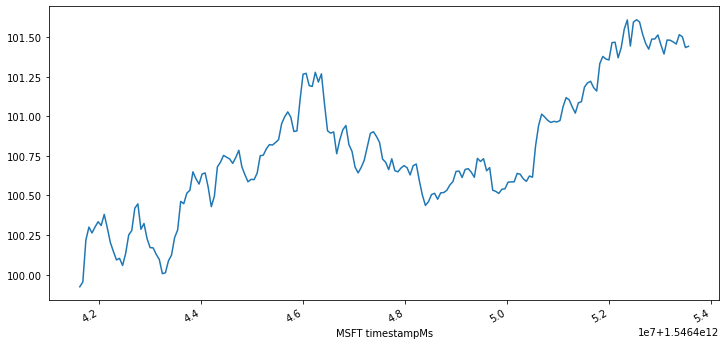

In [26]:
df[ta_weighted_price][:200].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dbccc9390>],
      dtype=object)

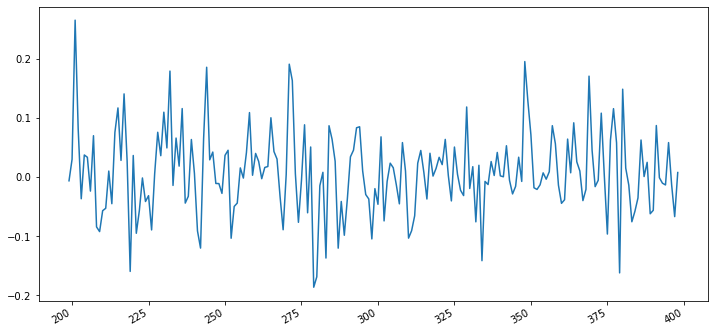

In [27]:
df[ta_price_change][:200].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dbcc230d0>],
      dtype=object)

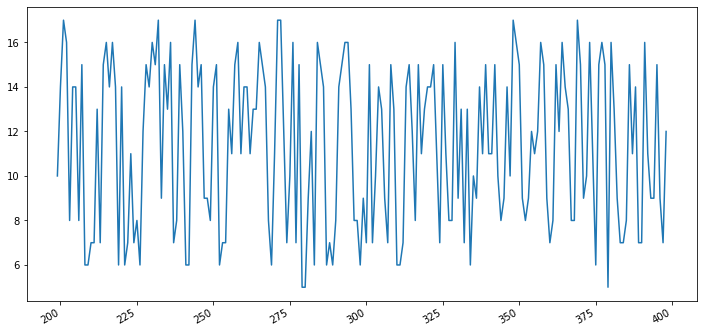

In [28]:
df[ta_price_change_class][:200].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dbcbb1390>],
      dtype=object)

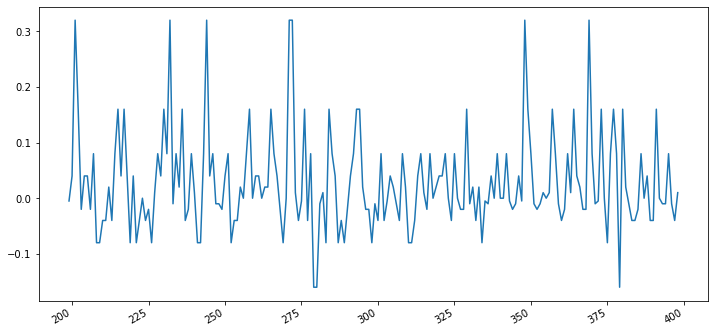

In [29]:
df[ta_price_change_class][:200].apply(func = lambda x : percentage_from_category(x)).plot(subplots=True)

Let's now create the data for the univariate model. For part 1, the model will be given the last 60 stock prices, and needs to learn to predict the stock price at the next time step. 

In [30]:
past_history_size = 15

uni_data_set = data_set[:, 0]
x_train_uni, y_train_uni = univariate_data(uni_data_set, labels_set, 0, TRAIN_SPLIT,
                                           past_history_size)
x_val_uni, y_val_uni = univariate_data(uni_data_set, labels_set, TRAIN_SPLIT, None,
                                       past_history_size)

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [31]:
def create_time_steps(length):
  return list(range(-length, 0))

In [32]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

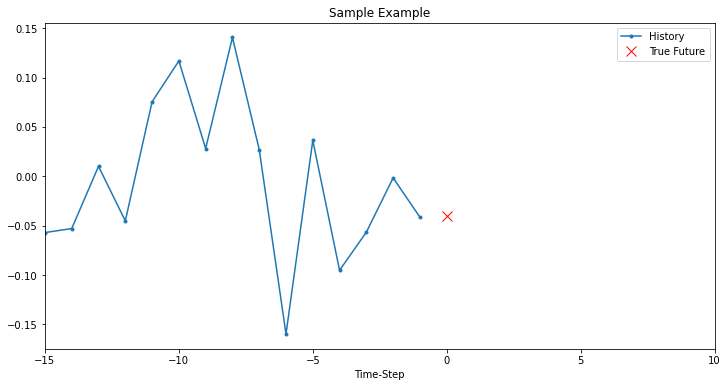

In [33]:
indx = 11
past = x_train_uni[indx]
future = percentage_from_category(y_train_uni[indx])
show_plot([past, future], 0, 'Sample Example')
# print(y_train_uni[:])

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

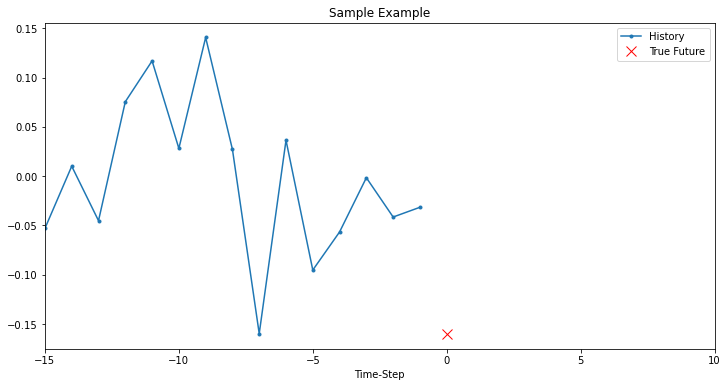

In [34]:
indx = 12
past = x_train_uni[indx]
future = percentage_from_category(y_train_uni[indx])
show_plot([past, future], 0, 'Sample Example')

In [82]:
print(np.unique(labels_set))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


### Recurrent neural network

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [36]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#train_univariate = train_univariate.take(k).cache().repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [37]:
print(x_train_uni.shape)
print(np.unique(labels_set))

(116270, 15, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [38]:
EVALUATION_INTERVAL = 5000
EPOCHS = 20

Define the optimizers we will be experimenting with:

In [39]:
optmzer_rms=tf.keras.optimizers.RMSprop()
optmzer_adam=tf.keras.optimizers.Adam(learning_rate=0.001)
init = RandomUniform(minval=-0.05, maxval=0.05)

Define a simple LSTM model:

In [40]:
simple_lstm_model = tf.keras.models.Sequential()
simple_lstm_model.add(tf.keras.layers.LSTM(units=128, input_shape=x_train_uni.shape[-2:]))
simple_lstm_model.add(tf.keras.layers.Dropout(0.1))
#simple_lstm_model.add(tf.keras.layers.Flatten(input_shape=x_train_uni.shape[-2:]))
simple_lstm_model.add(tf.keras.layers.Dense(units=256, activation='relu'))
simple_lstm_model.add(tf.keras.layers.Dense(number_of_classes, activation='softmax'))



simple_lstm_model.summary()
#simple_lstm_model.compile(optimizer=optmzer_adam, loss='mse', metrics=['mae', 'mean_absolute_percentage_error'])
simple_lstm_model.compile(optimizer=optmzer_adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy', 'mae', 'mse', 'mean_absolute_percentage_error'])

simple_lstm_model_checkpoint_path = "simple_lstm_model/cp-{epoch:04d}.ckpt"
simple_lstm_model_checkpoint_dir = os.path.dirname(simple_lstm_model_checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=simple_lstm_model_checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 verbose=1)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-5,
                                       patience=2,
                                       verbose=1)

# Loads the weights
simple_lstm_model_latest = tf.train.latest_checkpoint(simple_lstm_model_checkpoint_dir)
print(simple_lstm_model_checkpoint_dir)
if simple_lstm_model_latest:
    #simple_lstm_model.load_weights(simple_lstm_model_latest)
    print("----- Model weights reloaded! -----")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 21)                5397      
Total params: 104,981
Trainable params: 104,981
Non-trainable params: 0
_________________________________________________________________
simple_lstm_model


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 2000 steps on JupyterLab (or 200 on Colab), instead of the complete training data as normally done.

In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

single_step_univar_loss_history = simple_lstm_model.fit(train_univariate, 
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=200,
                      callbacks=[early_stopping, callback_reduce_lr, cp_callback]
                      )

Epoch 1/20
1486/5000 [=======>......................] - ETA: 14s - loss: 2.9678 - accuracy: 0.1424 - mae: 9.9707 - mse: 108.6546 - mean_absolute_percentage_error: 2105.6262

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the validation data using `evaluate`
print('\n# Evaluate on validation data')
results = simple_lstm_model.evaluate(val_univariate, steps=200)

In [ ]:
plot_train_history(single_step_univar_loss_history,
                   'Single Step Training and validation loss')

#### Predict using the simple LSTM model
Now that we have trained our simple LSTM, let's try and make a few predictions.

In [ ]:
for x, y in val_univariate.take(30):
    true_future = percentage_from_category(y[0])
    pr = simple_lstm_model.predict(x)[0]
    arx = tf.math.argmax(pr)
    #print("true=%s -- predict=%s" % (true_future, tf.print(arx))
    tf.print("true=%s -- predict=%s" % (y[0], arx + 1))
    predicted_future = percentage_from_category(tf.cast(arx, tf.float32) + 1)
    plot = show_plot([x[0].numpy(), true_future, predicted_future], 0, 'Simple LSTM model')
    plot.show()

## Part 2: Predict a multivariate time series

In [42]:
print(data_set[-5:])

[[-1.90114068e-02 -4.43540154e-01  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  9.96065241e-01  1.00120751e+00
   1.00634537e+00  9.96340960e-01  1.00128308e+00  1.00550757e+00
   9.88442783e-01  9.93605780e-01  9.98641557e-01  9.72638281e-01
   9.78411314e-01  9.82956992e-01  9.37981185e-01  9.43721046e-01
   9.48818103e-01  8.99795936e-01  9.06393455e-01  9.12852140e-01
   8.54081824e-01  8.60990131e-01  8.67612186e-01  1.00123151e+00
   1.00056328e+00  9.99895057e-01  1.00087931e+00  1.00019111e+00
   9.99502898e-01  4.56315548e-01  4.21052632e-01  3.20292398e-01
  -1.48879395e-02 -4.83632619e-03 -1.00516133e-02]
 [ 1.90150219e-02 -4.36674712e-01  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  9.95875875e-01  1.00101717e+00
   1.00615405e+00  9.96151542e-01  1.00109272e+00  1.00531641e+00
   9.88254867e-01  9.93416882e-01  9.98451702e-01  9.72453369e-01
   9.78225305e-01  9.82770118e-01  9.37802861e-01  9.43541631e-01
   9.48637719e-01  8.9962

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of trade aggregations over the past sampled every few minutes. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [43]:
def multivariate_data(dataset, target, start_index, end_index, history_size, step):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])
    labels.append(target[i])

  return np.array(data), np.array(labels)

In [44]:
past_history = 15
STEP = 1

x_train_multi, y_train_multi = multivariate_data(data_set, labels_set, 0, TRAIN_SPLIT, past_history, STEP)
x_val_multi, y_val_multi = multivariate_data(data_set, labels_set, TRAIN_SPLIT, None, past_history, STEP)

Let's check out a sample data-point.

In [45]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target price to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (15, 39)

 Target price to predict : ()


In [46]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


Plotting a sample data-point.

In [47]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = 1

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every minute.

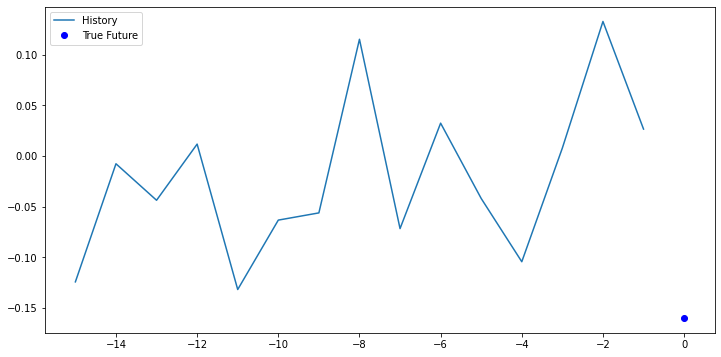

In [48]:
for x, y in train_data_multi.take(1):
    indx = 0
    true_future = percentage_from_category(y[indx])
    multi_step_plot(x[indx], true_future, np.array([0]))
    #show_plot([x[0].numpy(), true_future, predicted_future], 0, 'LSTM model')

In [49]:
optmzer_rms=tf.keras.optimizers.RMSprop()
optmzer_adam=tf.keras.optimizers.Adam(learning_rate=0.001)
def cost(y_true,y_pred):
    tf.reduce_mean(tf.square(tf.sub(y_true,y_pred)))

In [83]:
weights = np.arange(1,number_of_classes + 1, dtype='float64')
print(weights)

@tf.function
def normalize(xx):
#     print("tesnor shape %s " % xx.shape)
#     print("before %s ")
#     tf.print(xx)
    result = tf.tensordot(xx, weights, axes=(1, 0))
#     print("after %s ")
#     tf.print(result)
#     print("result shape %s " % result.shape)
    return tf.math.add(result, -1)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21.]


Define a more sophisticated model:

In [100]:
tf.keras.backend.set_floatx('float64')
print(x_train_multi.shape[-2:])
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(128, input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
# multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
#multi_step_model.add(tf.keras.layers.LSTM(128, activation='relu'))
#multi_step_model.add(tf.keras.layers.LSTM(25, activation='relu'))
# multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
#multi_step_model.add(tf.keras.layers.Flatten())
multi_step_model.add(tf.keras.layers.Dense(128))
multi_step_model.add(tf.keras.layers.Dense(number_of_classes, activation='softmax'))

#tf.keras.layers.Dot()([pp, ww])
# multi_step_model.add(tf.keras.layers.Dense(1, activation='softmax'))
#- tf.constant(1.0, dtype='float64'
multi_step_model.add(tf.keras.layers.Lambda(lambda xx: normalize(xx) ))

#, metrics=['accuracy', 'mean_absolute_percentage_error', 'mae']
multi_step_model.compile(optimizer=optmzer_adam, loss='mse', metrics=['mae', 'mean_absolute_percentage_error'])
#multi_step_model.compile(optimizer=optmzer_adam, loss='mse', metrics=['mean_absolute_percentage_error', 'mae'])
multi_step_model.summary()

(15, 39)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 128)               86016     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_40 (Dense)             (None, 21)                2709      
_________________________________________________________________
lambda_5 (Lambda)            (None,)                   0         
Total params: 105,237
Trainable params: 105,237
Non-trainable params: 0
_________________________________________________________________


In [95]:
# tf.keras.backend.set_floatx('float64')
# multi_step_model = tf.keras.models.Sequential()
# multi_step_model.add(tf.keras.layers.Conv1D(7, 3, activation='relu', padding='causal', input_shape=x_train_multi.shape[-2:]))
# multi_step_model.add(tf.keras.layers.Conv1D(7, 5, activation='relu', padding='causal'))
# multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True))
# #multi_step_model.add(tf.keras.layers.LSTM(128))
# multi_step_model.add(tf.keras.layers.LSTM(8, return_sequences=True))
# multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
# #multi_step_model.add(tf.keras.layers.Conv1D(7, 3, activation='relu', padding='causal'))
# #multi_step_model.add(tf.keras.layers.Conv1D(3, 5, activation='relu', padding='causal'))
# multi_step_model.add(tf.keras.layers.Dense(32))
# multi_step_model.add(tf.keras.layers.Dense(1))

# multi_step_model.compile(optimizer=optmzer_adam, loss='mse', metrics=['accuracy', 'mean_absolute_percentage_error', 'mae'])
# multi_step_model.summary()

Let's see how the model predicts before it trains.

In [96]:
for x, y in val_data_multi.take(1):
  print(x.shape)
  print (multi_step_model.predict(x).shape)

(256, 15, 39)
(256,)


In [97]:
multi_step_model_checkpoint_path = "multi_step_model/cp-{epoch:04d}.ckpt"
multi_step_model_checkpoint_dir = os.path.dirname(multi_step_model_checkpoint_path)

# Loads the weights
multi_step_model_latest = tf.train.latest_checkpoint(multi_step_model_checkpoint_dir)
if multi_step_model_latest:
    multi_step_model.load_weights(multi_step_model_latest)
    print("----- Model weights reloaded! -----")

In [104]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=multi_step_model_checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 verbose=1)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-6,
                                       patience=2,
                                       verbose=1)

multi_step_history = multi_step_model.fit(train_data_multi, epochs=50,
                                          steps_per_epoch=10000,
                                          validation_data=val_data_multi,
                                          validation_steps=200,
                                          callbacks=[early_stopping, callback_reduce_lr, cp_callback]
                                          )

Epoch 1/50
10000/10000 [==============================] - ETA: 0s - loss: 8.5331 - mae: 2.4998 - mean_absolute_percentage_error: 365597.9081
Epoch 00001: val_loss improved from inf to 5.88294, saving model to multi_step_model/cp-0001.ckpt
INFO:tensorflow:Assets written to: multi_step_model/cp-0001.ckpt/assets
10000/10000 [==============================] - 161s 16ms/step - loss: 8.5331 - mae: 2.4998 - mean_absolute_percentage_error: 365597.9081 - val_loss: 5.8829 - val_mae: 1.9839 - val_mean_absolute_percentage_error: 355154.9015 - lr: 1.0000e-06
Epoch 2/50
 9997/10000 [============================>.] - ETA: 0s - loss: 8.5308 - mae: 2.4995 - mean_absolute_percentage_error: 360259.3879
Epoch 00002: val_loss did not improve from 5.88294
10000/10000 [==============================] - 158s 16ms/step - loss: 8.5307 - mae: 2.4995 - mean_absolute_percentage_error: 360151.3185 - val_loss: 5.8835 - val_mae: 1.9840 - val_mean_absolute_percentage_error: 354906.6559 - lr: 1.0000e-06
Epoch 3/50
1000

In [105]:
# Evaluate the model on the validation data using `evaluate`
print('\n# Evaluate on validation data')
results = multi_step_model.evaluate(val_data_multi, steps=200)


# Evaluate on validation data
200/200 [==============================] - 2s 8ms/step - loss: 5.8829 - mae: 1.9839 - mean_absolute_percentage_error: 355154.9015


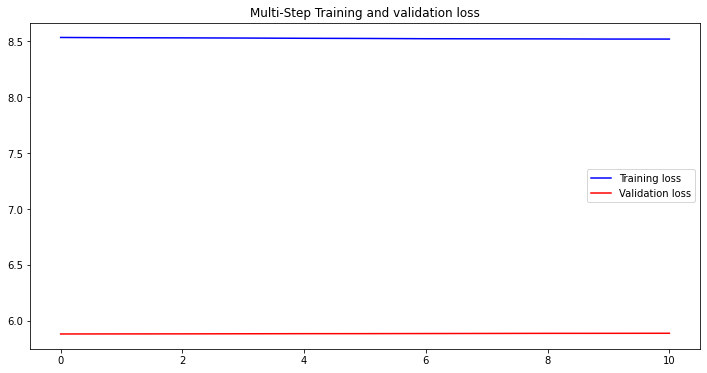

In [106]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well our network has learnt to predict the future.

true=-0.04 -- predict=-0.01


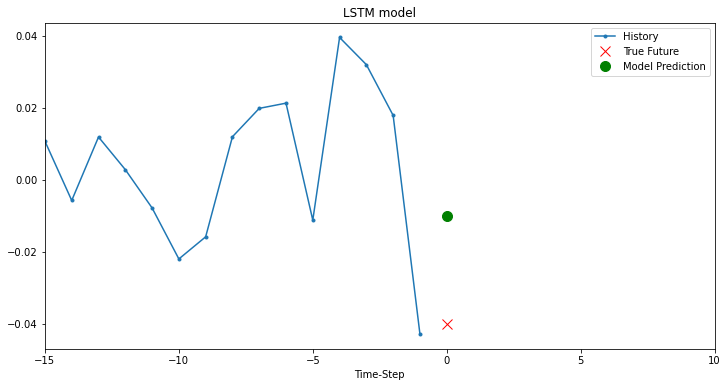

true=-0.04 -- predict=-0.01


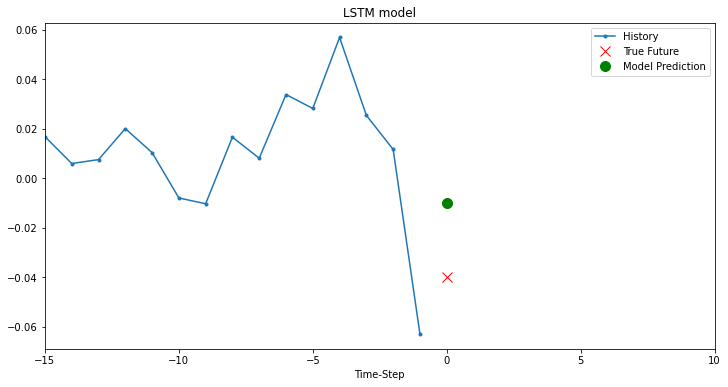

true=-0.005 -- predict=-0.005


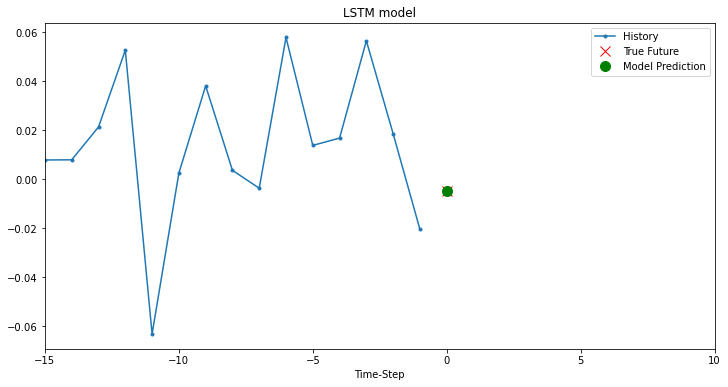

true=-0.005 -- predict=-0.005


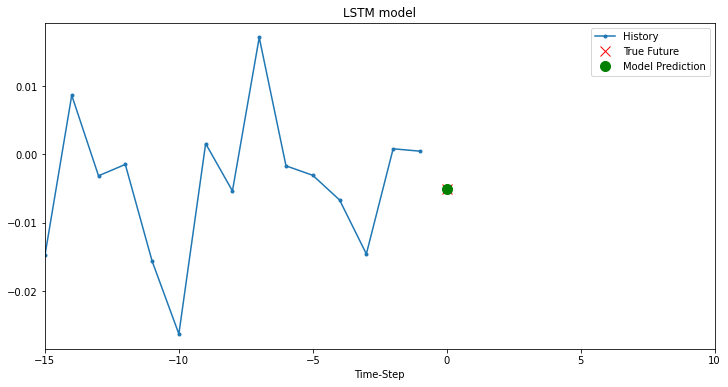

true=0.01 -- predict=-0.005


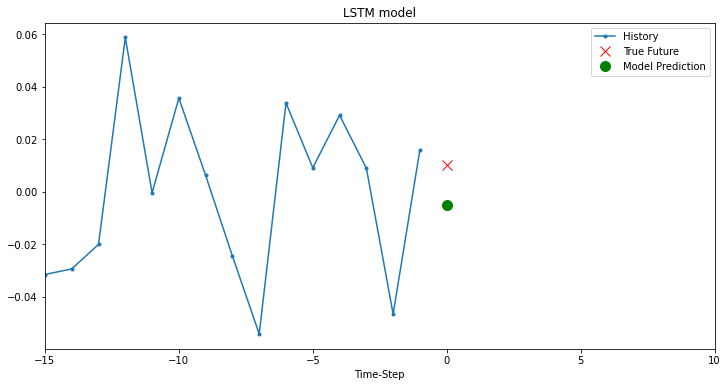

true=-0.005 -- predict=-0.005


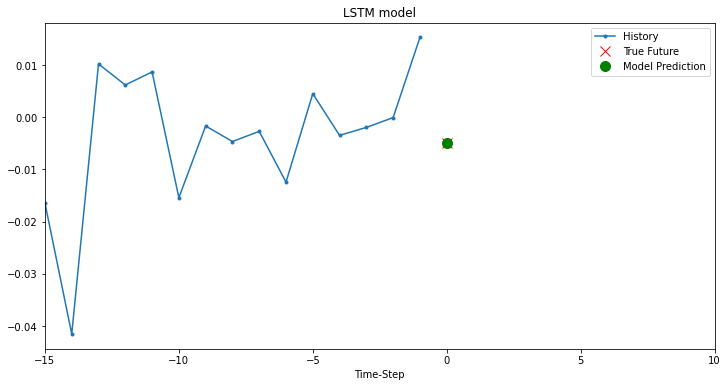

true=-0.02 -- predict=-0.005


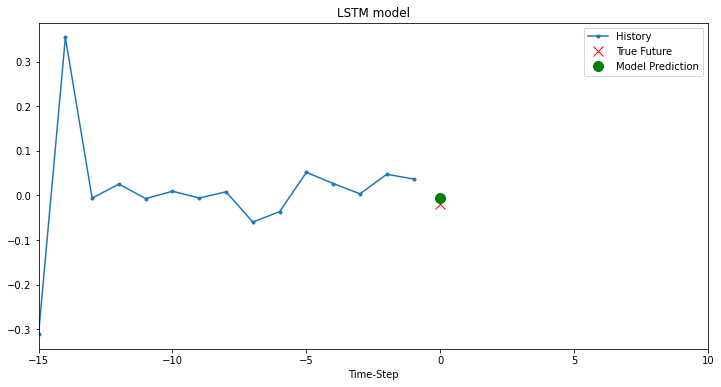

true=-0.04 -- predict=-0.005


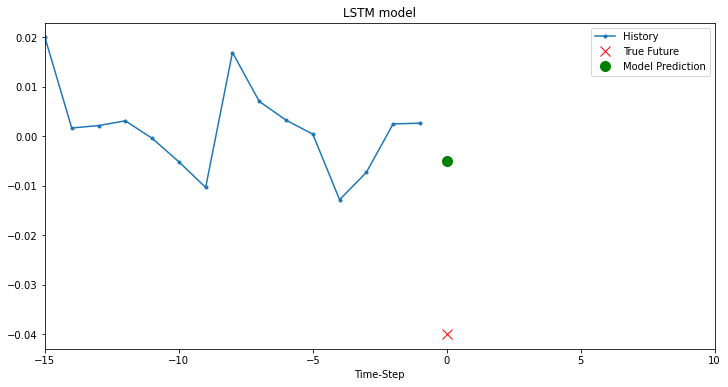

true=-0.16 -- predict=-0.01


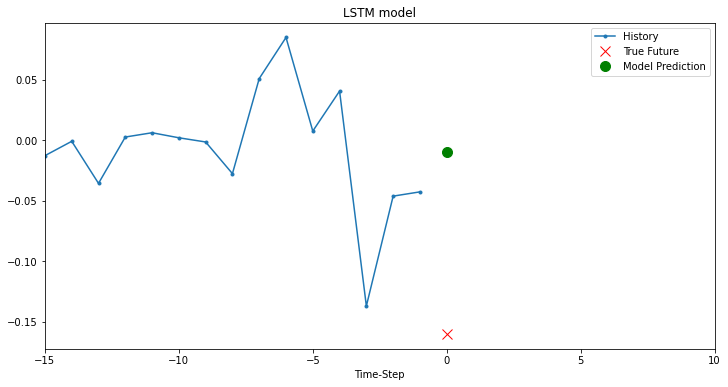

true=0 -- predict=-0.005


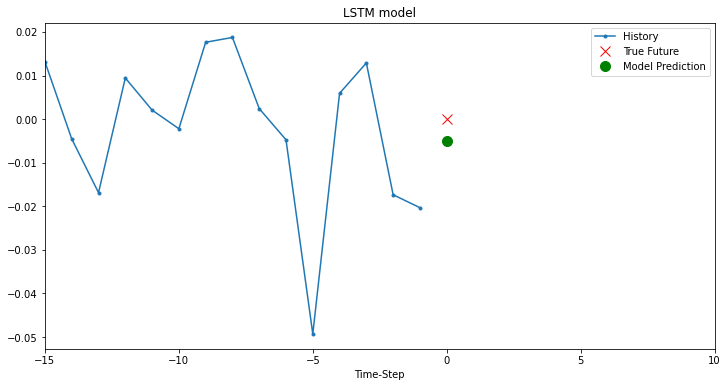

true=-0.02 -- predict=-0.005


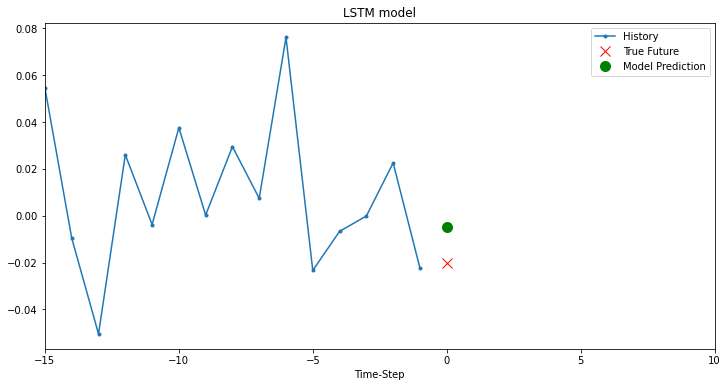

true=-0.02 -- predict=-0.005


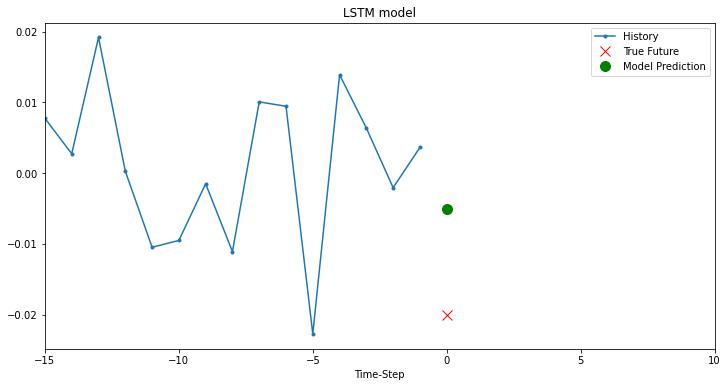

true=-0.005 -- predict=0


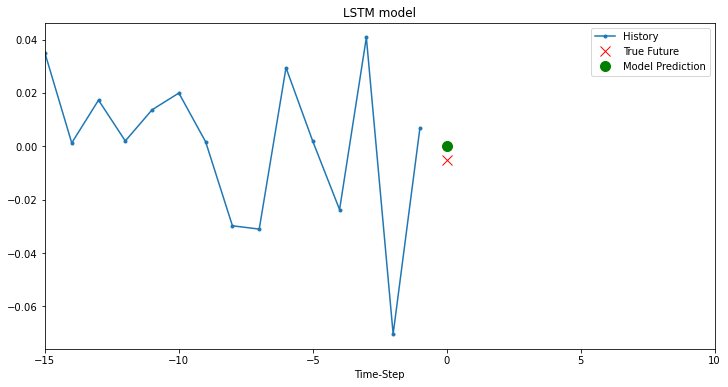

true=-0.01 -- predict=-0.005


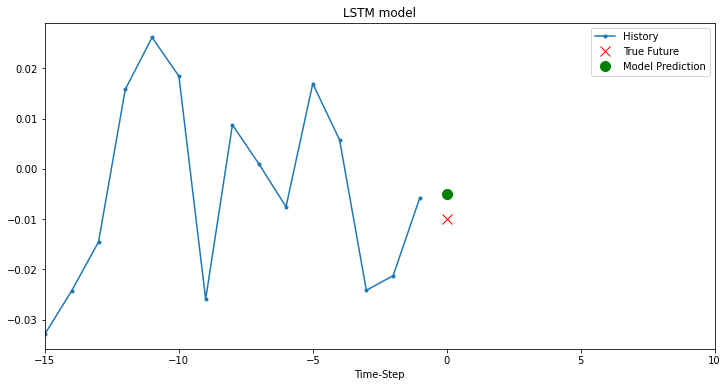

true=-0.01 -- predict=0


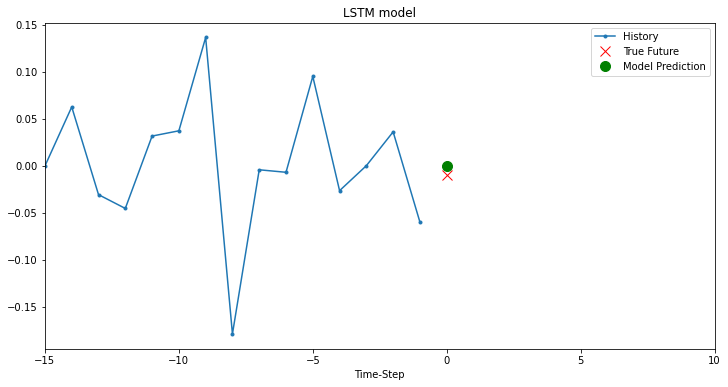

true=0.01 -- predict=0


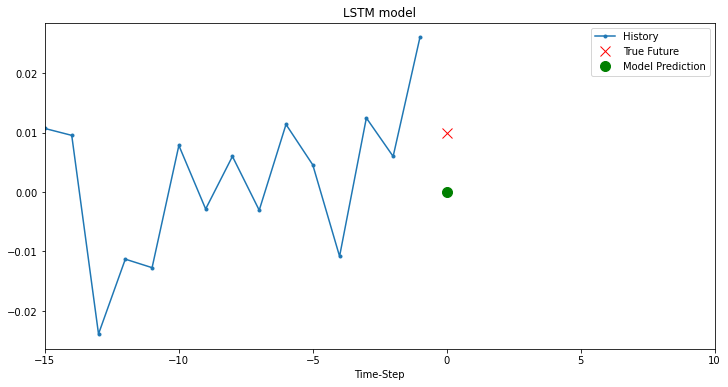

true=0.16 -- predict=0.02


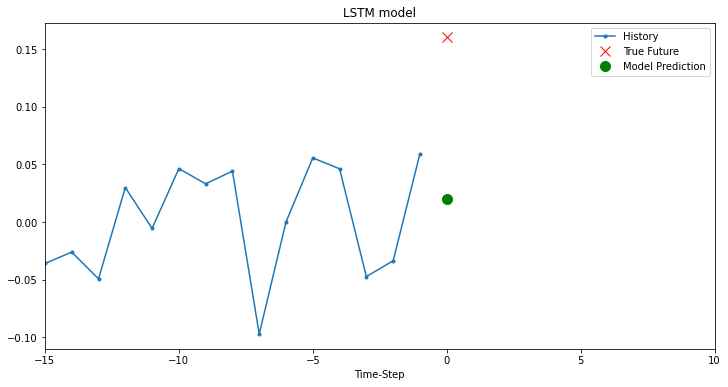

true=-0.04 -- predict=0


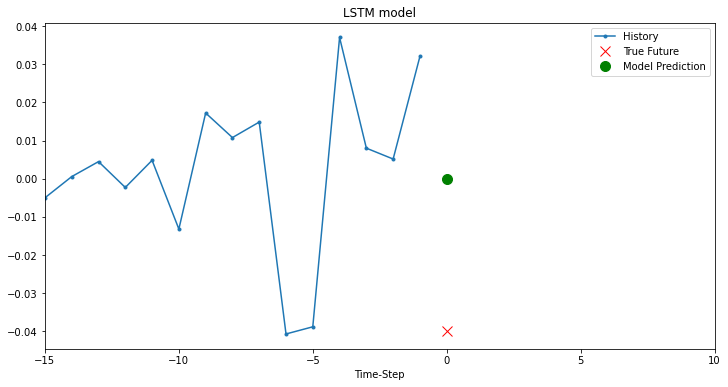

true=0.02 -- predict=0


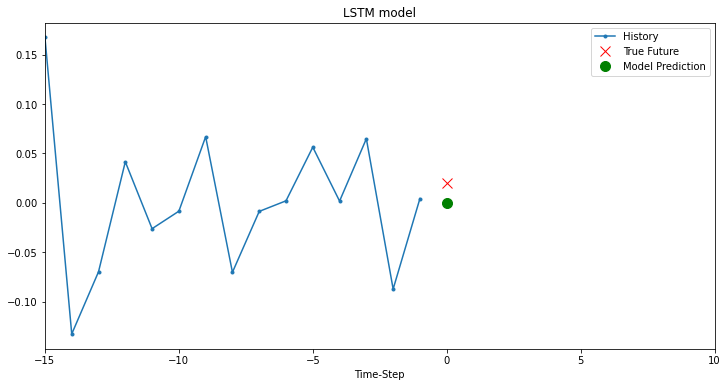

true=0.02 -- predict=-0.005


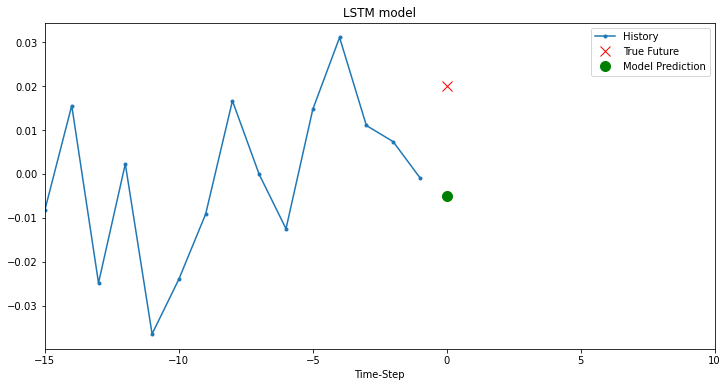

true=0 -- predict=-0.005


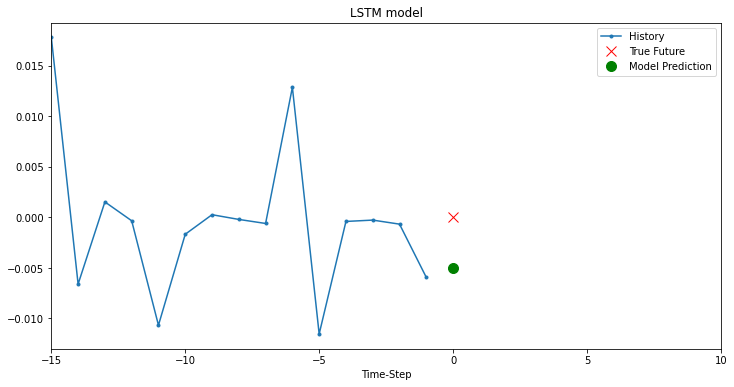

true=0.02 -- predict=0


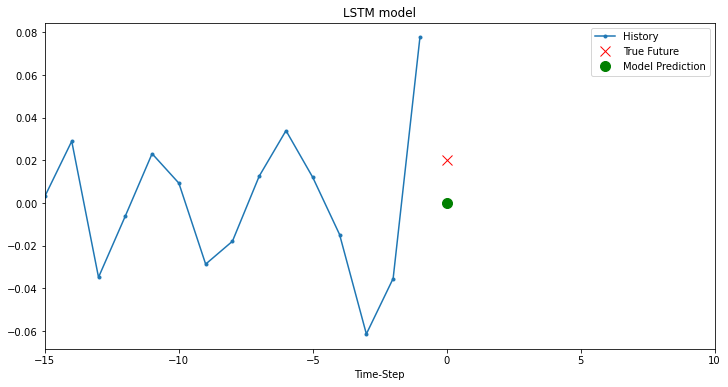

true=-0.005 -- predict=-0.005


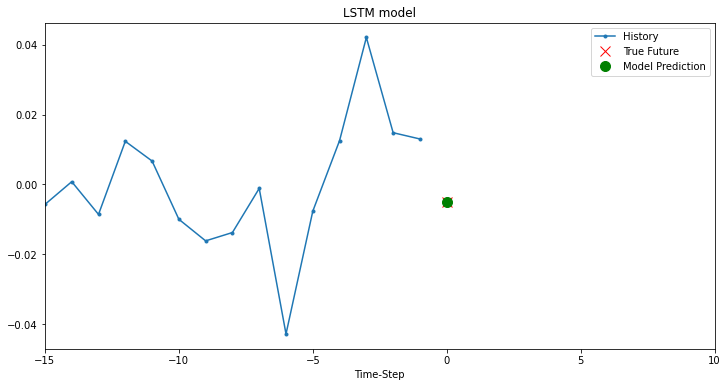

true=0.04 -- predict=-0.005


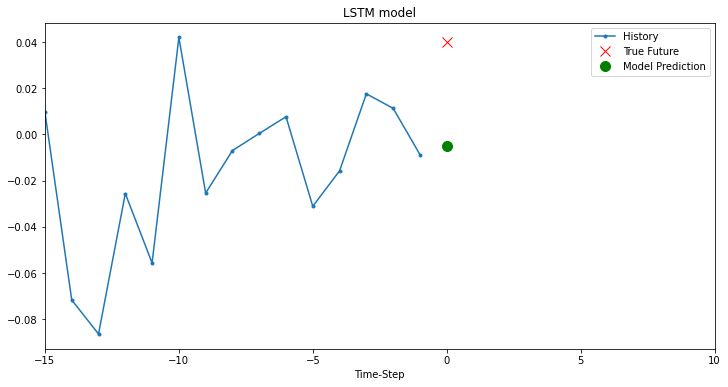

true=-0.005 -- predict=-0.01


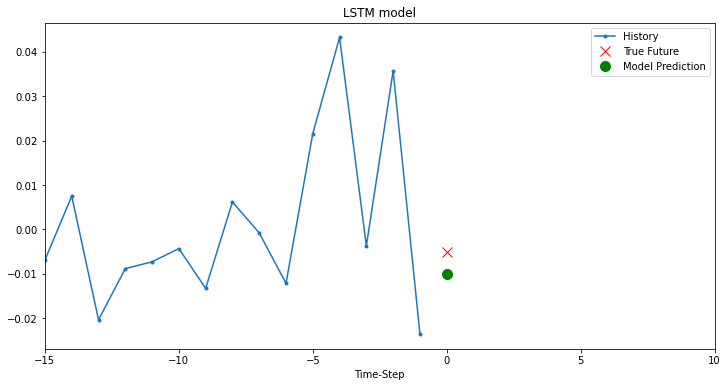

true=-0.08 -- predict=-0.005


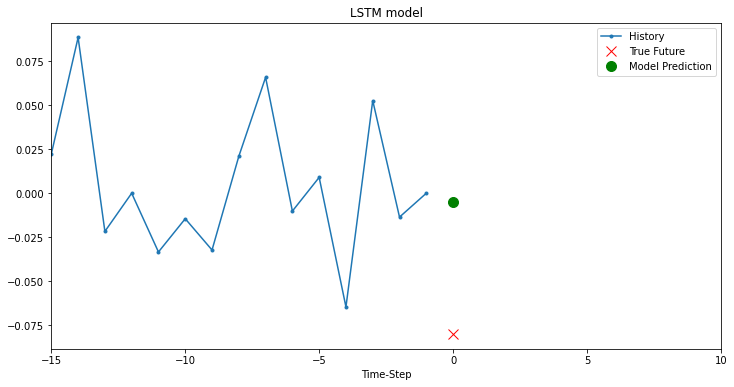

true=-0.16 -- predict=-0.01


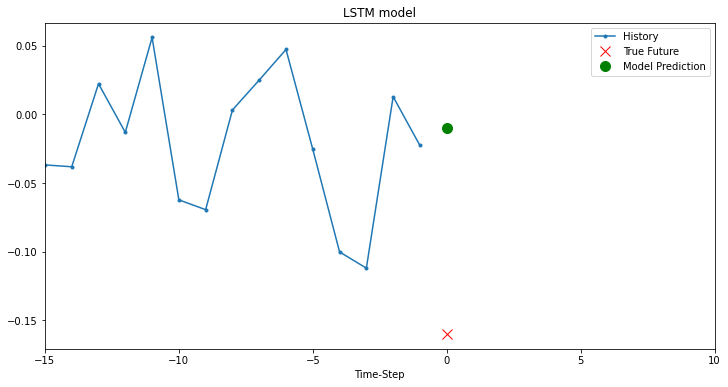

true=-0.005 -- predict=-0.005


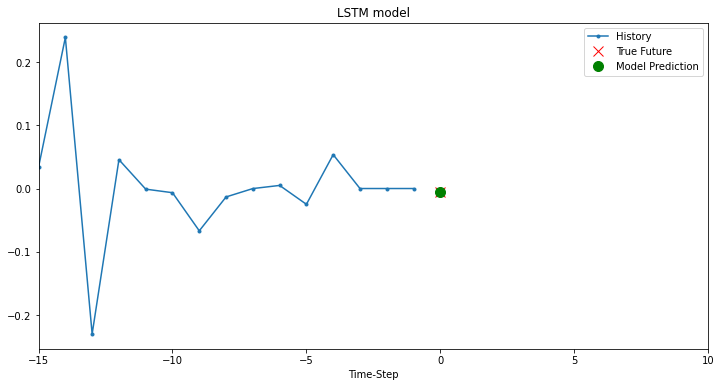

true=-0.02 -- predict=-0.005


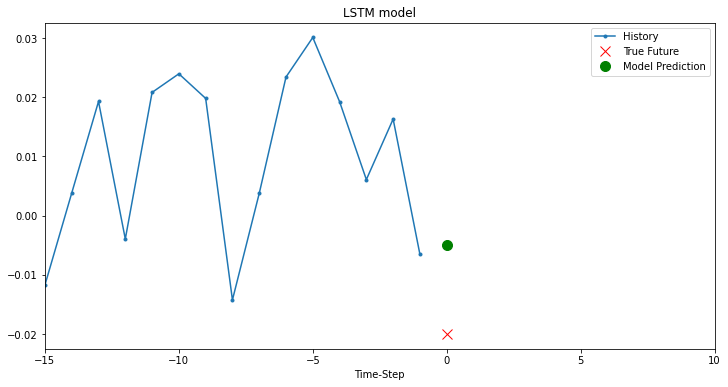

true=-0.04 -- predict=-0.005


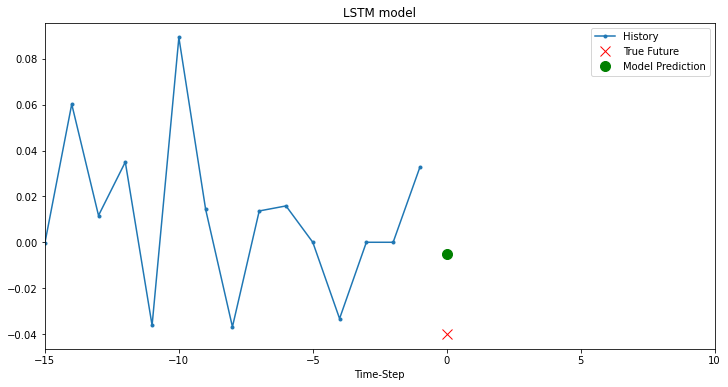

true=0.02 -- predict=0


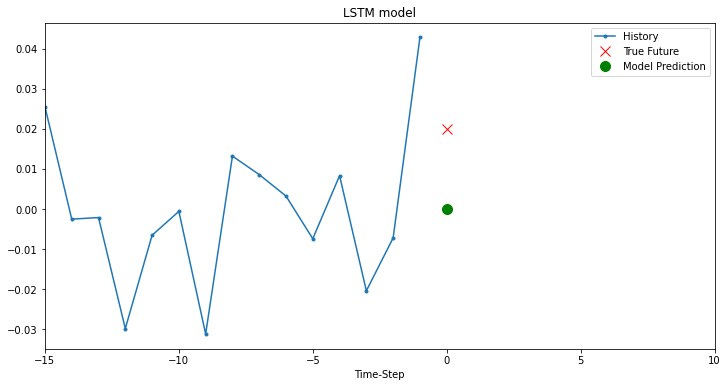

true=0.02 -- predict=0


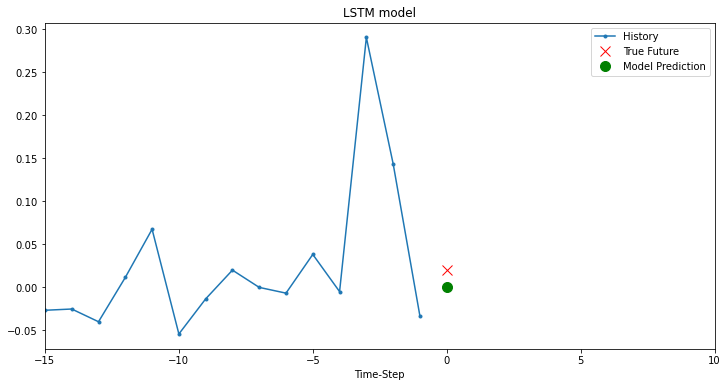

true=0.01 -- predict=-0.005


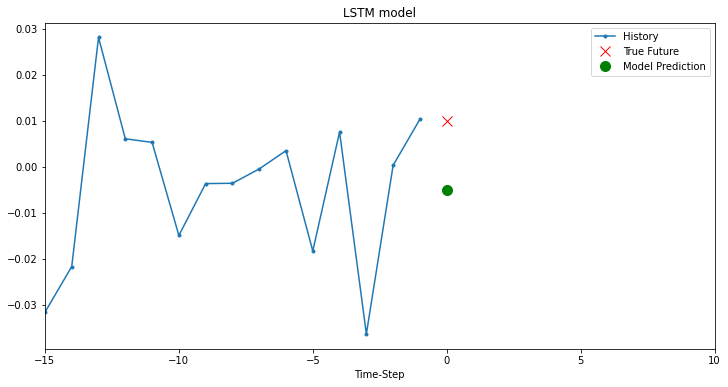

true=-0.02 -- predict=-0.005


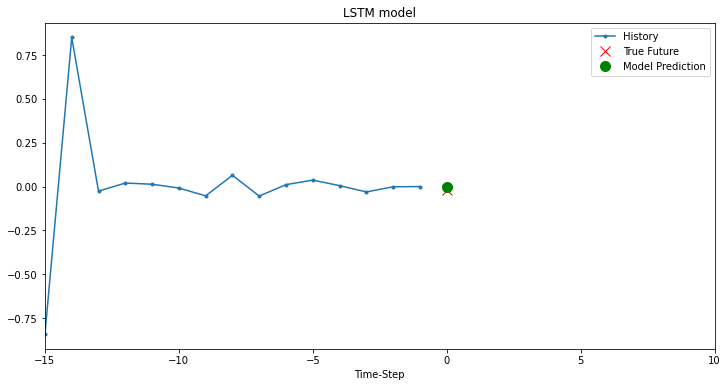

true=-0.04 -- predict=-0.005


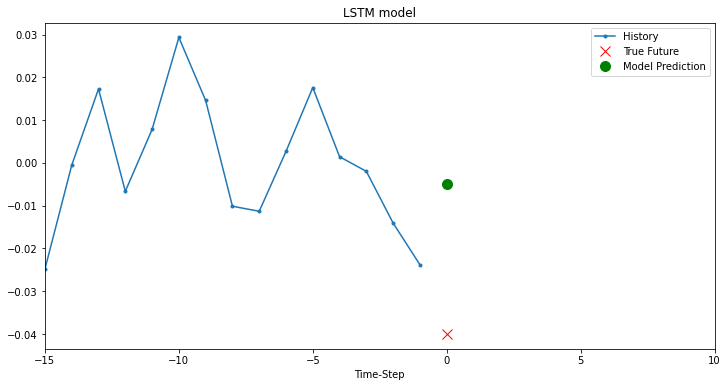

true=0.04 -- predict=-0.005


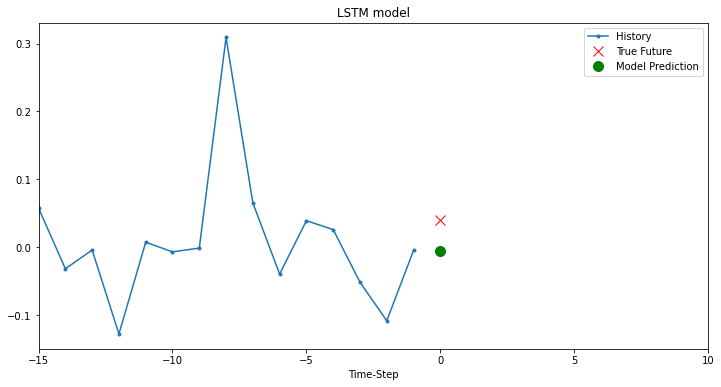

true=0.04 -- predict=-0.005


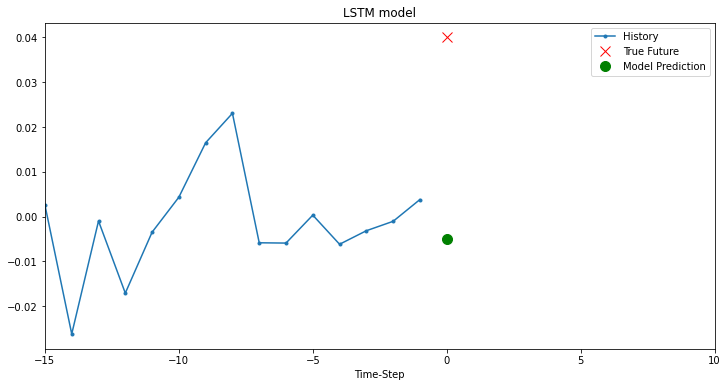

true=-0.005 -- predict=-0.01


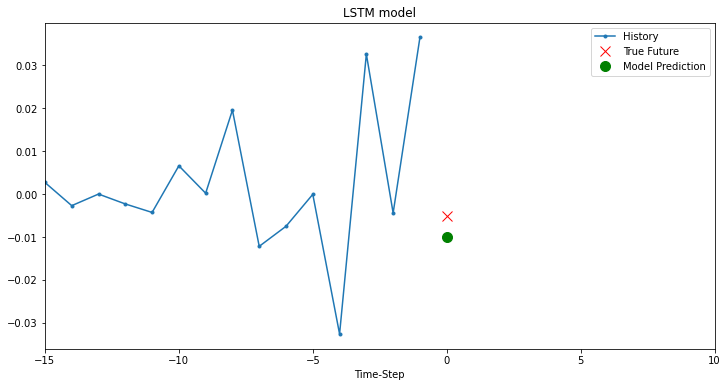

true=-0.02 -- predict=-0.005


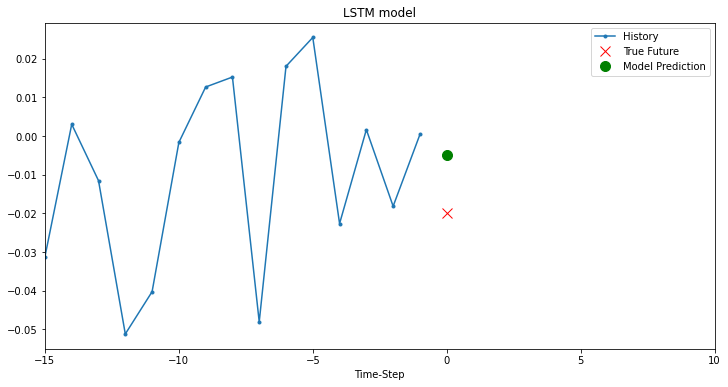

true=0.08 -- predict=0


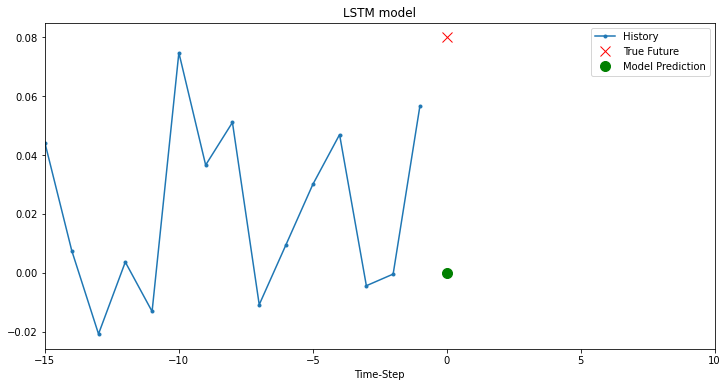

true=-0.02 -- predict=-0.01


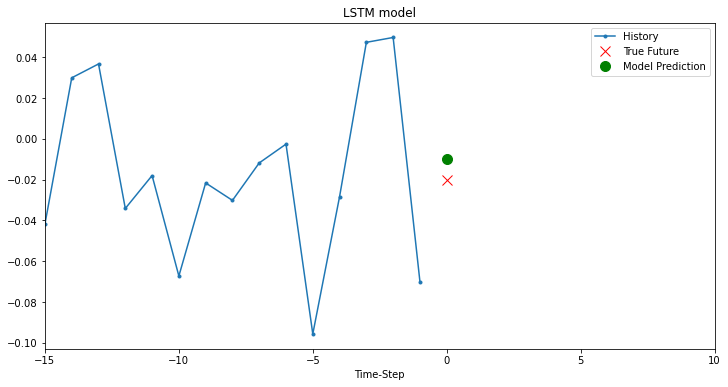

true=-0.04 -- predict=0


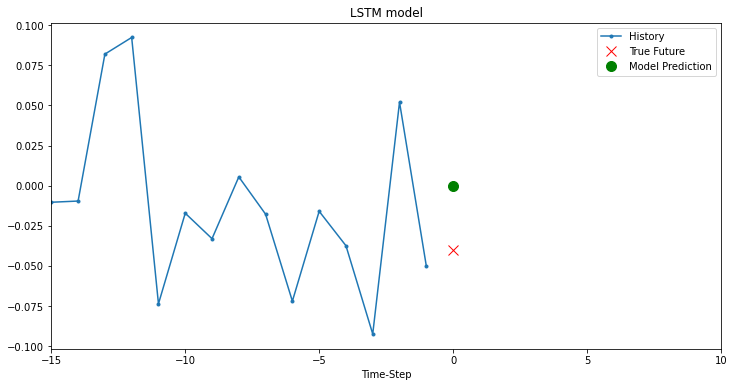

true=-0.005 -- predict=-0.005


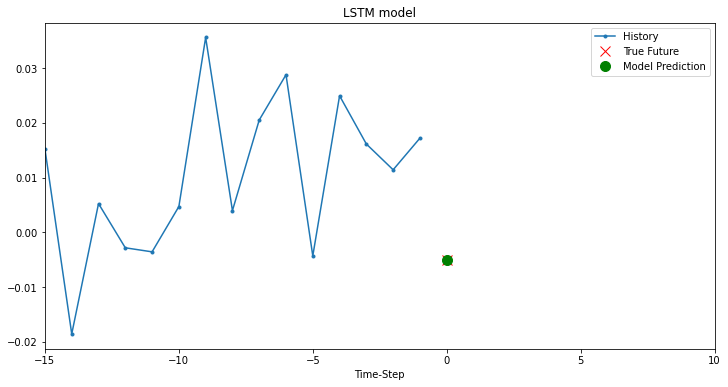

true=0 -- predict=-0.005


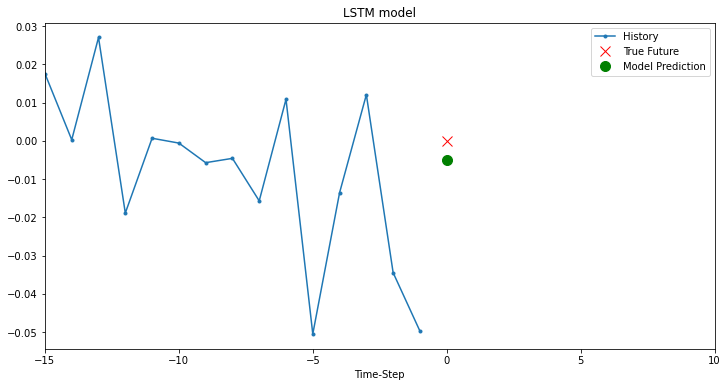

true=0.04 -- predict=-0.005


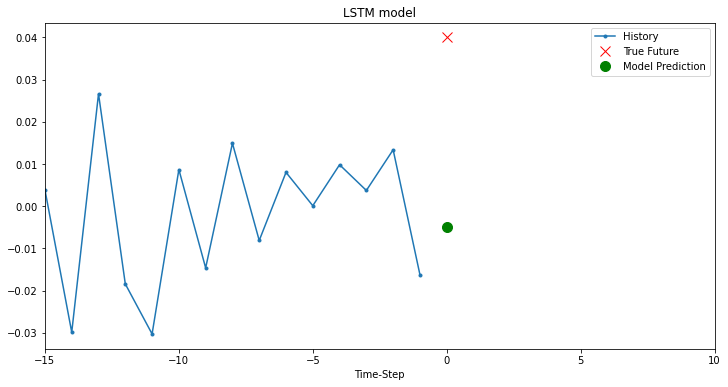

true=-0.04 -- predict=-0.005


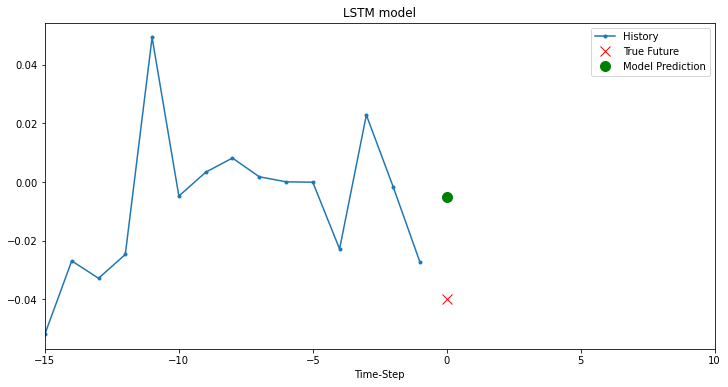

true=-0.005 -- predict=-0.005


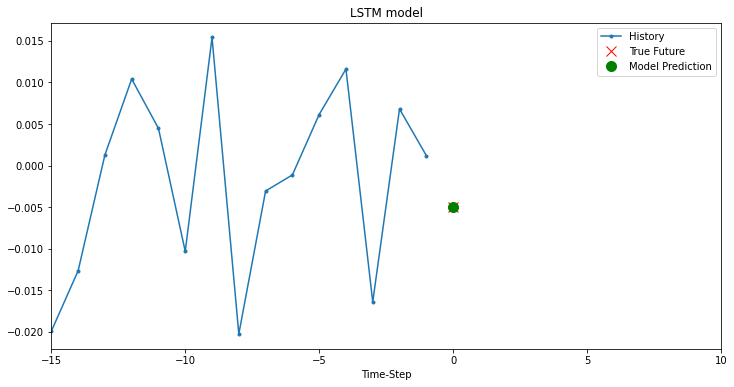

true=-0.04 -- predict=-0.005


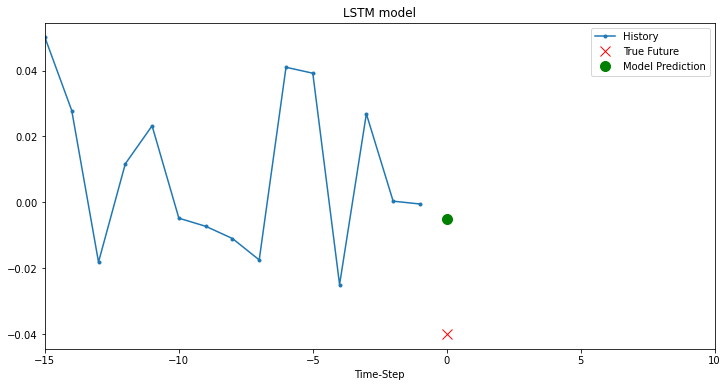

true=-0.005 -- predict=-0.005


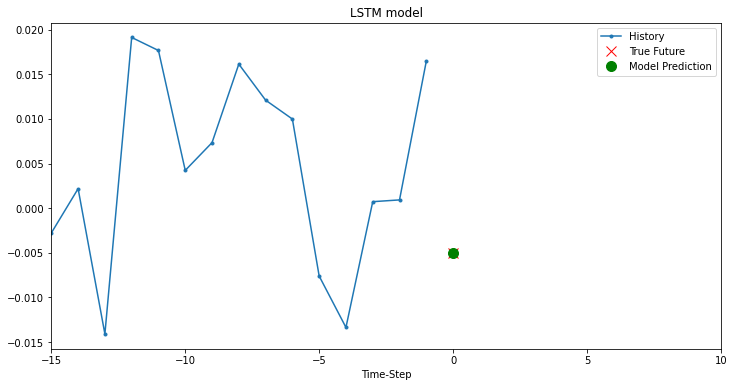

true=0.01 -- predict=-0.005


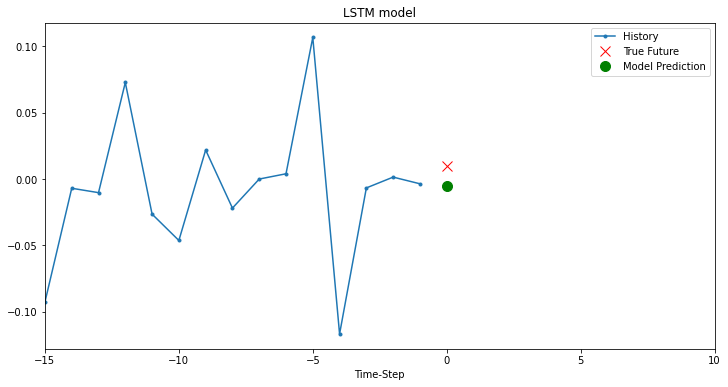

true=-0.005 -- predict=-0.005


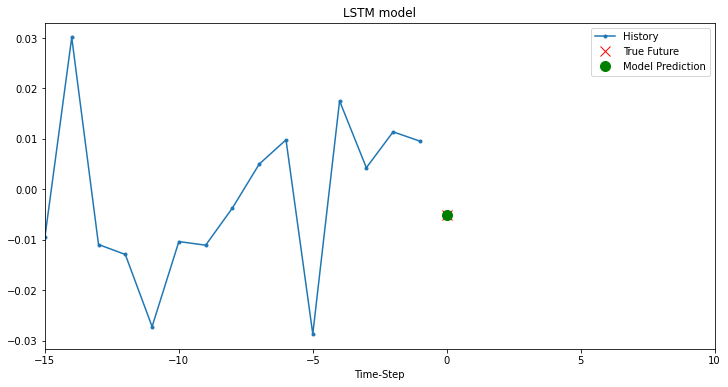

true=-0.005 -- predict=-0.005


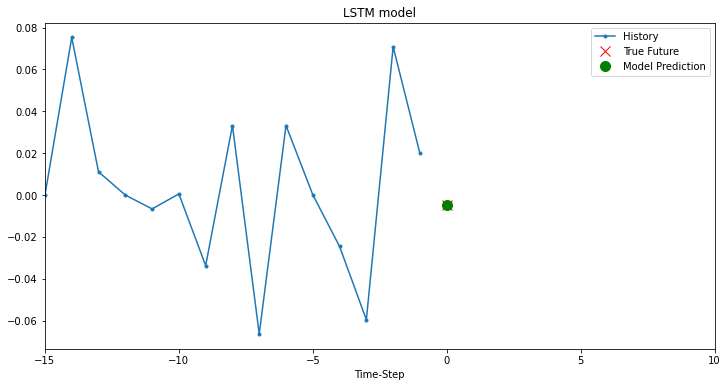

true=-0.02 -- predict=-0.005


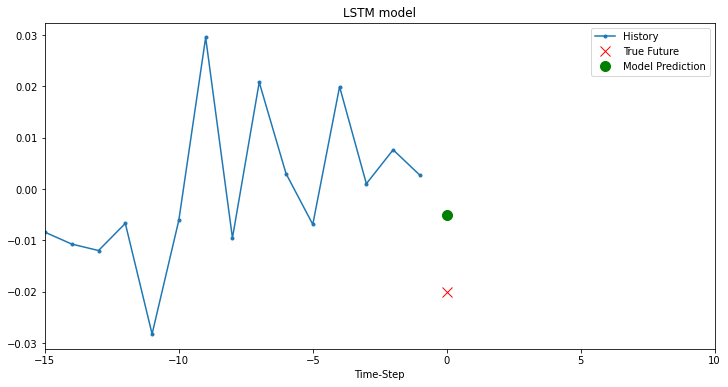

true=-0.08 -- predict=-0.005


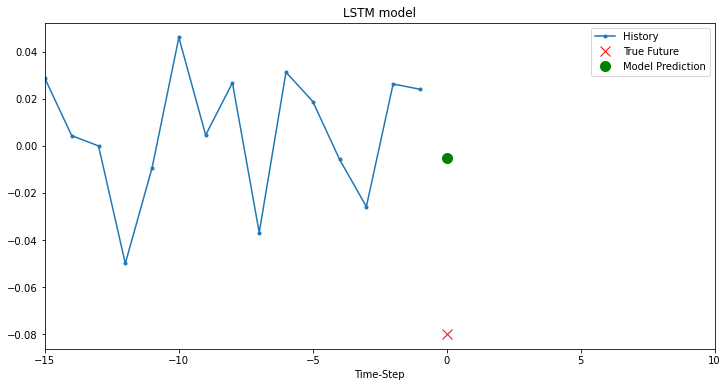

true=0.02 -- predict=0


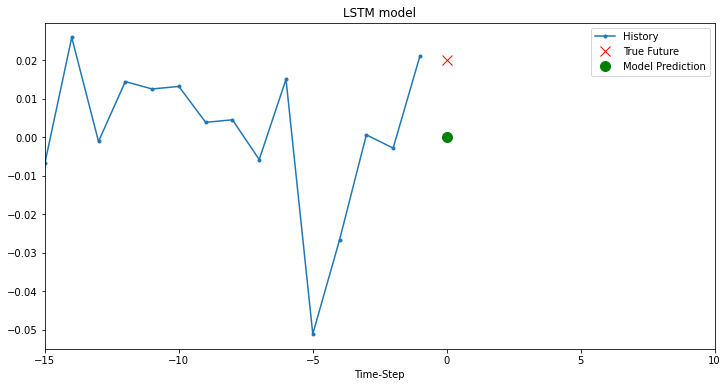

true=-0.08 -- predict=-0.005


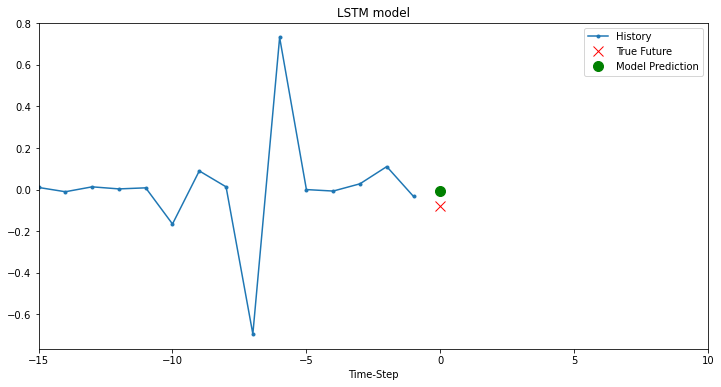

true=-0.005 -- predict=-0.005


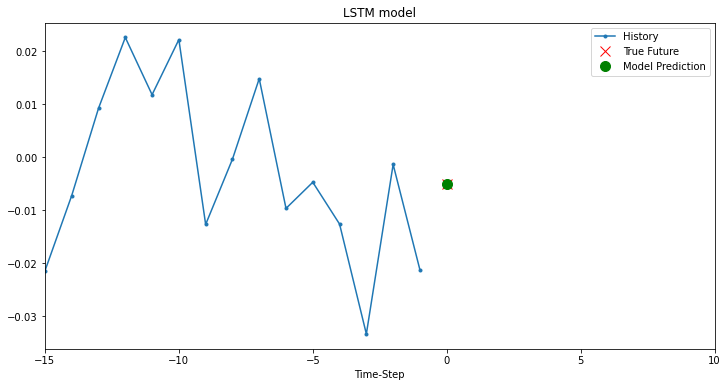

true=0.02 -- predict=-0.005


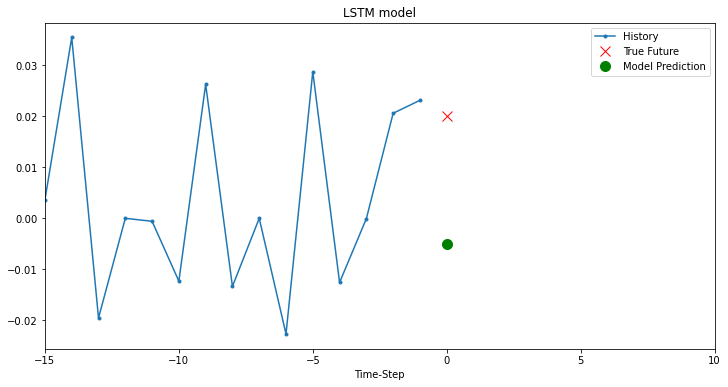

true=-0.04 -- predict=-0.01


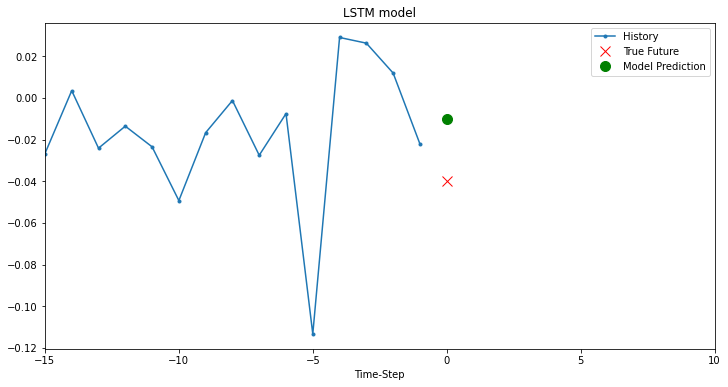

true=0.02 -- predict=-0.005


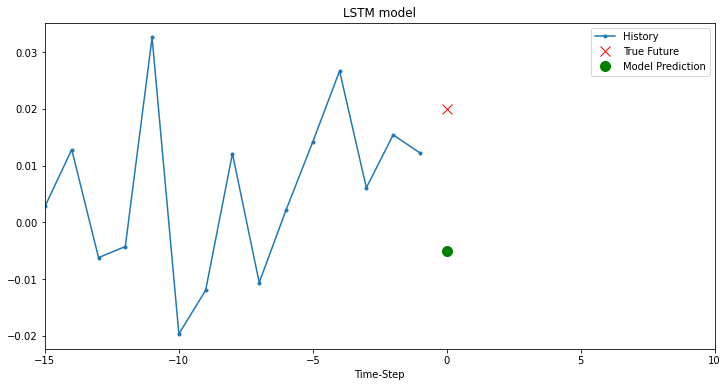

true=-0.02 -- predict=-0.01


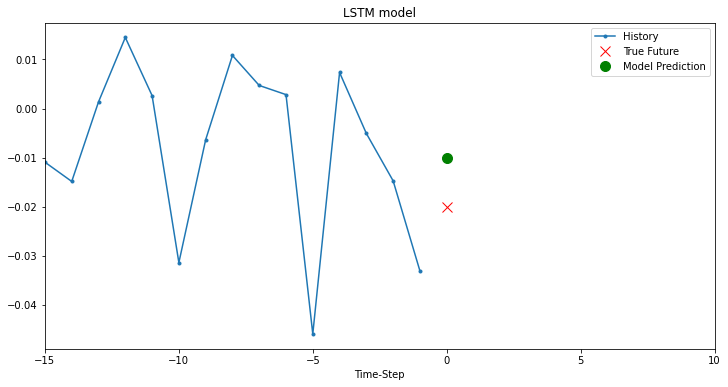

true=0.01 -- predict=-0.005


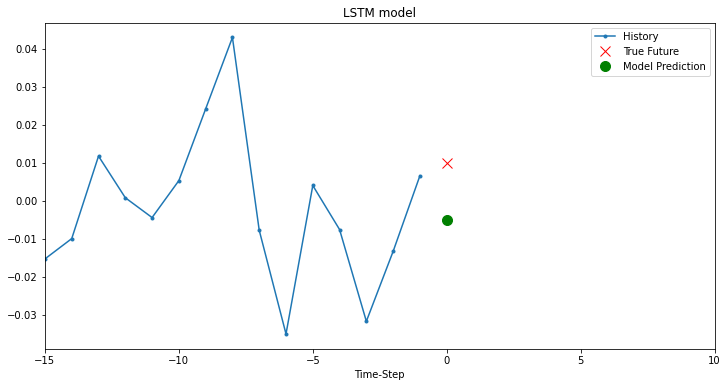

true=-0.04 -- predict=-0.005


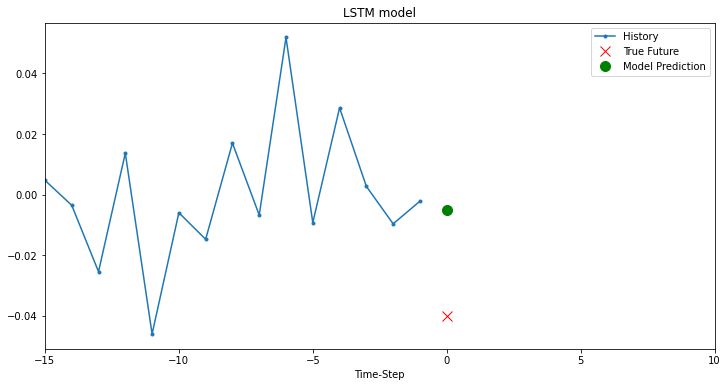

true=-0.005 -- predict=-0.005


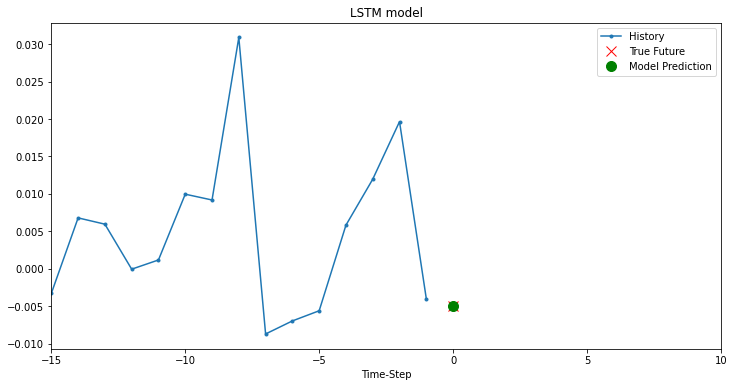

true=-0.005 -- predict=-0.005


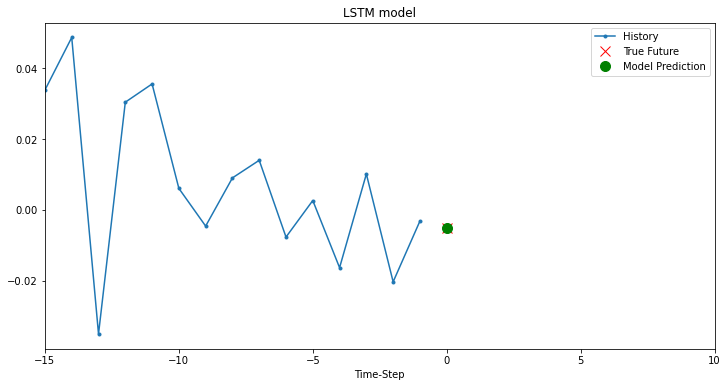

true=0 -- predict=-0.005


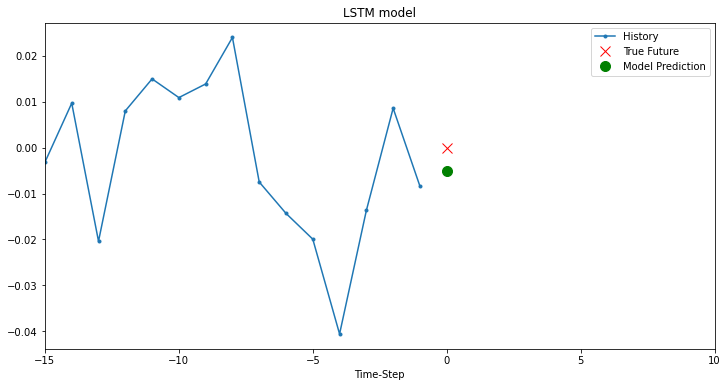

true=0.02 -- predict=-0.005


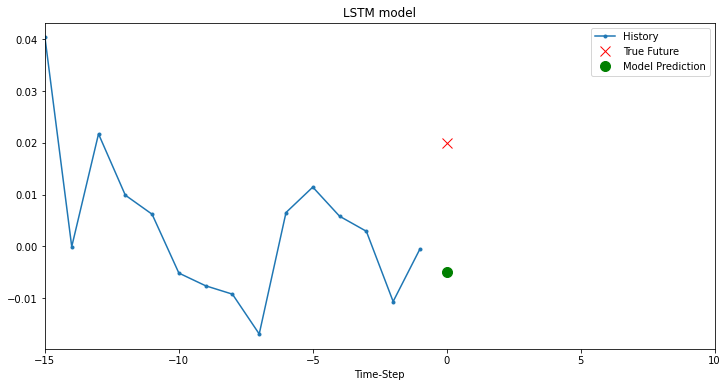

true=0.04 -- predict=-0.01


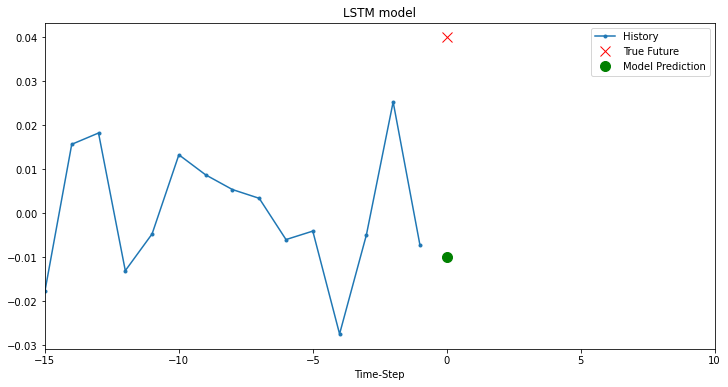

true=-0.005 -- predict=-0.005


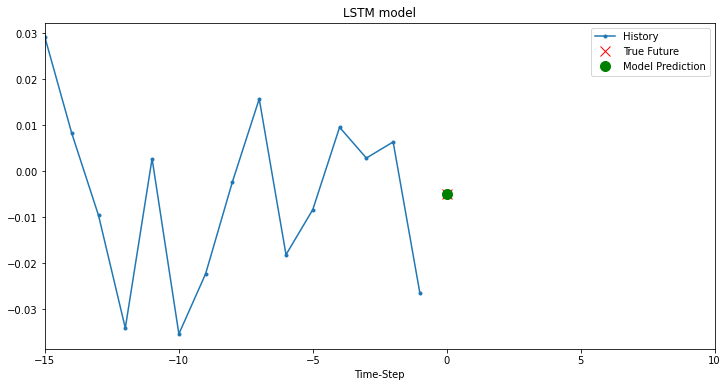

true=-0.02 -- predict=-0.005


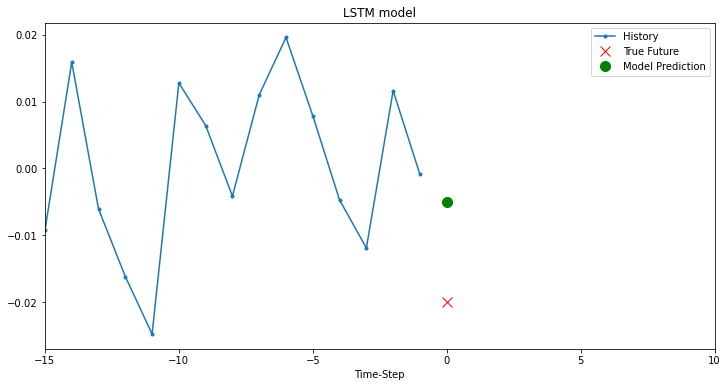

true=-0.02 -- predict=-0.005


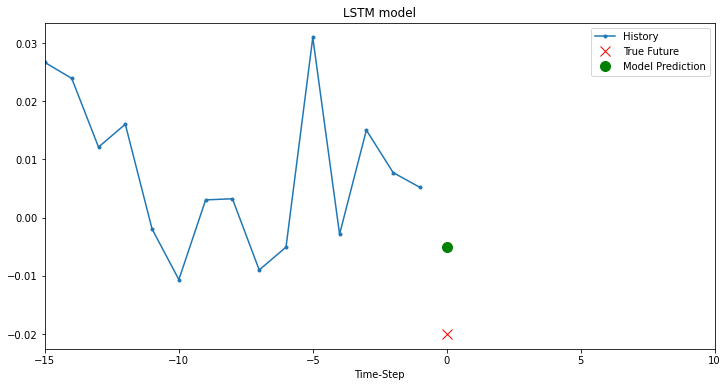

true=-0.01 -- predict=-0.005


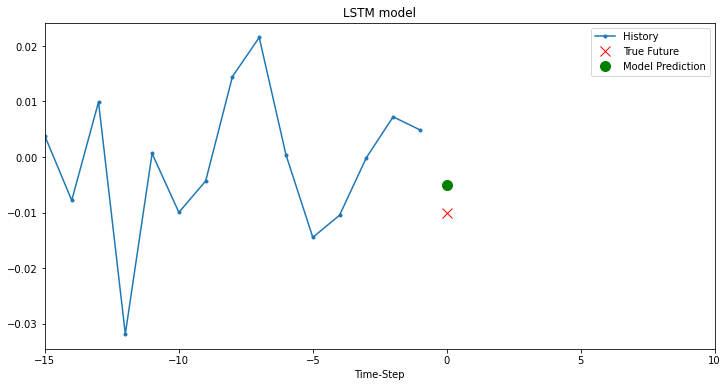

true=-0.005 -- predict=-0.005


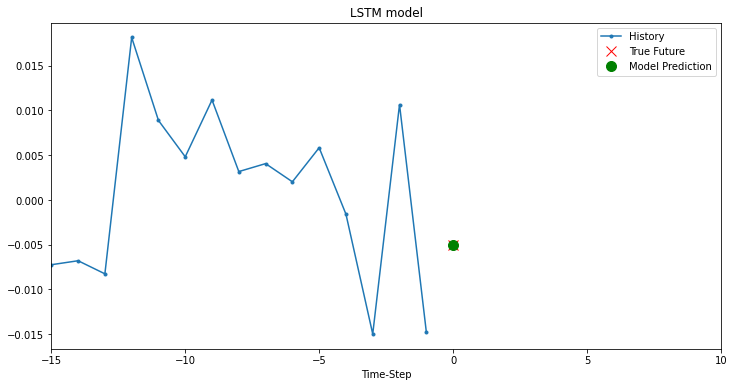

true=-0.005 -- predict=-0.005


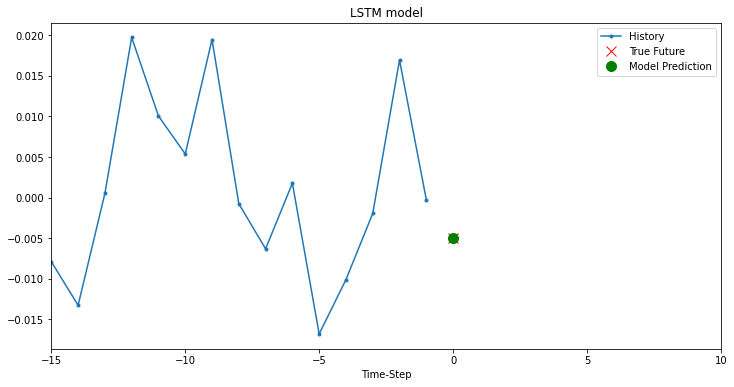

true=0.01 -- predict=-0.01


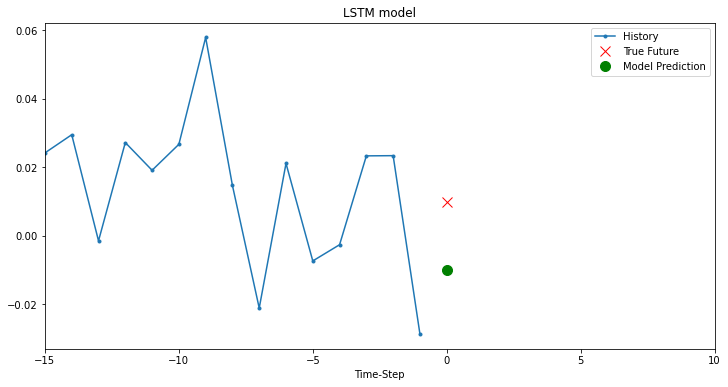

true=0.01 -- predict=-0.005


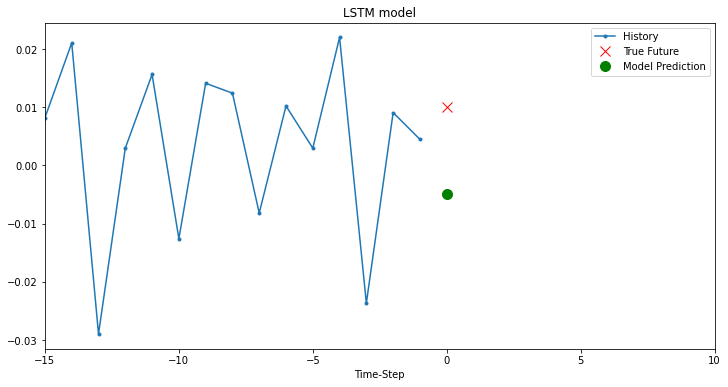

true=-0.01 -- predict=-0.01


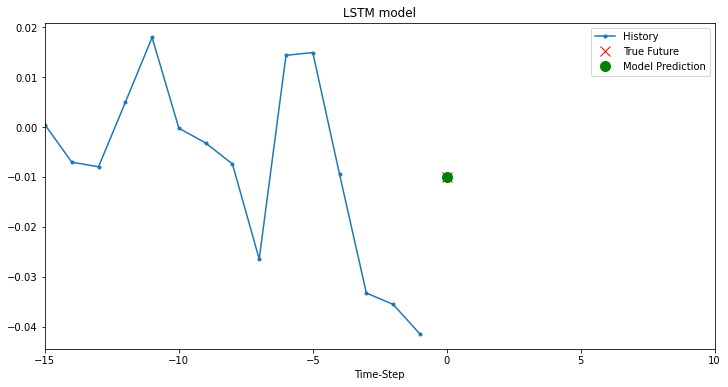

true=-0.08 -- predict=-0.005


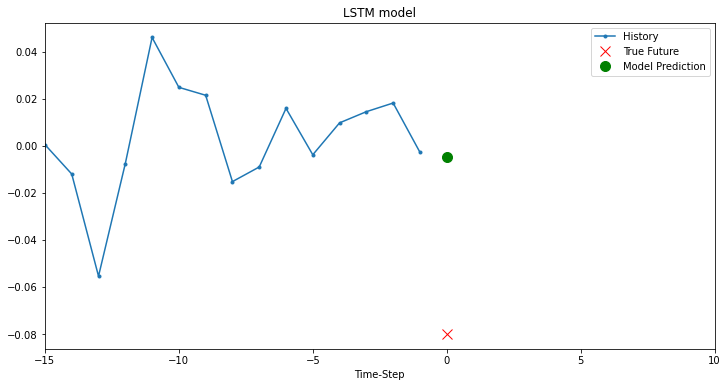

true=-0.04 -- predict=-0.01


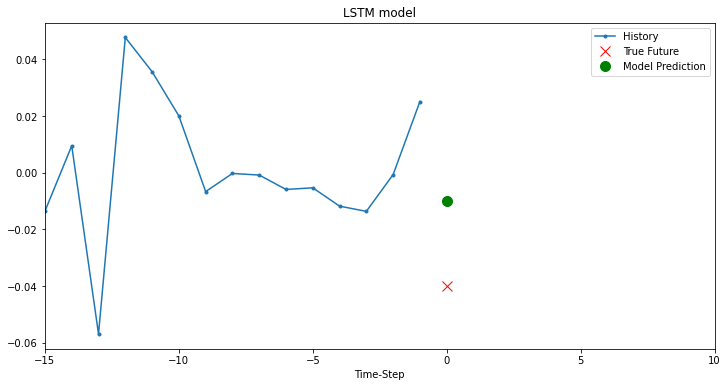

true=-0.01 -- predict=0


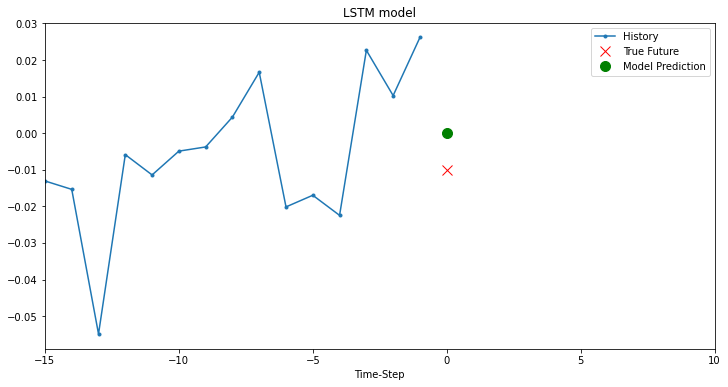

true=-0.04 -- predict=-0.005


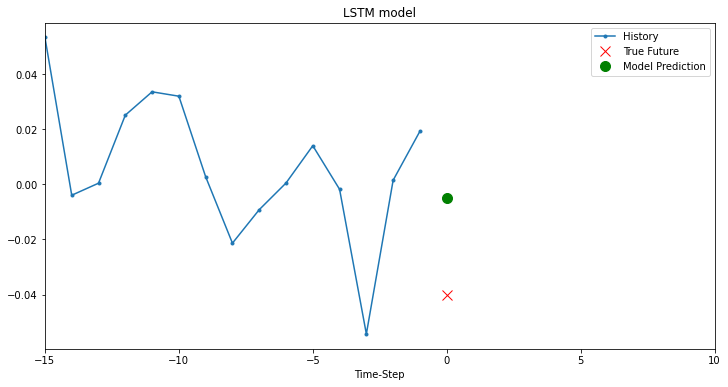

true=-0.04 -- predict=-0.01


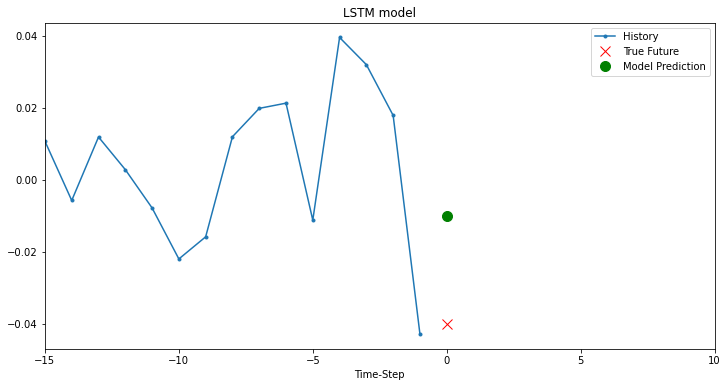

true=-0.04 -- predict=-0.01


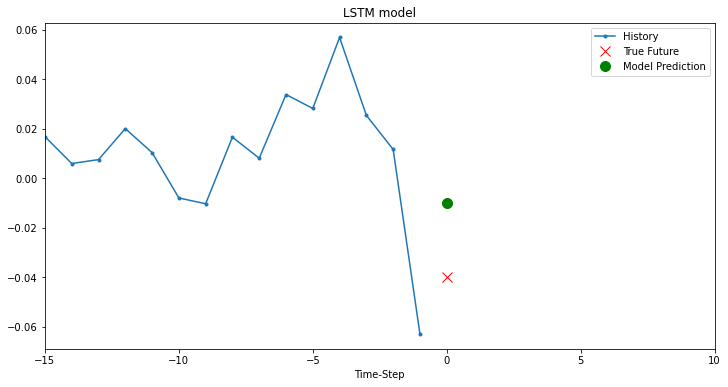

true=-0.005 -- predict=-0.005


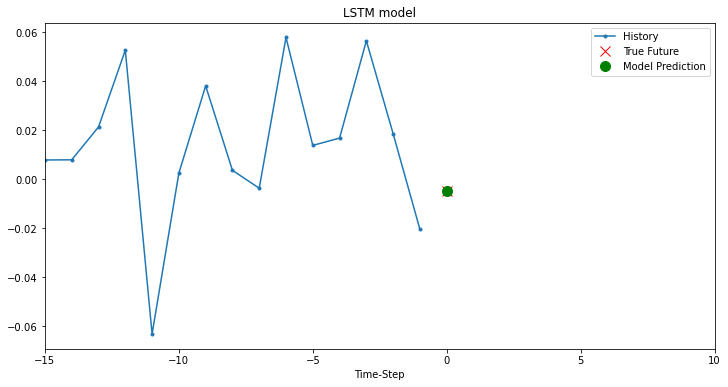

true=-0.005 -- predict=-0.005


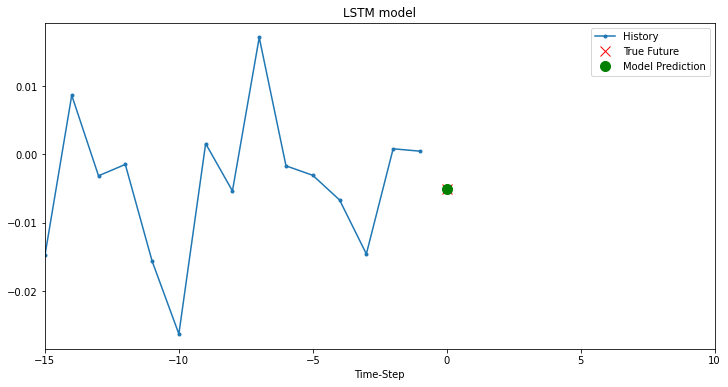

true=0.01 -- predict=-0.005


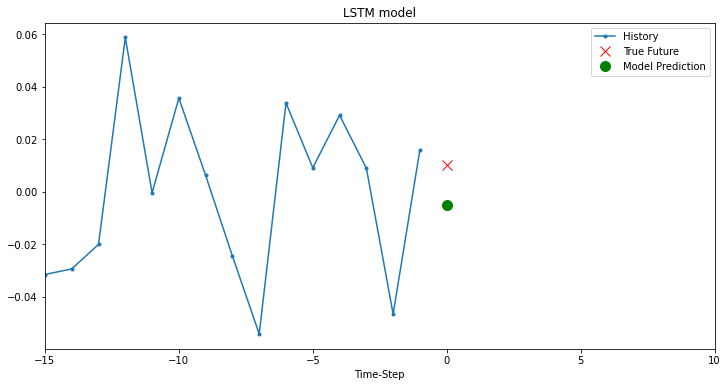

true=-0.005 -- predict=-0.005


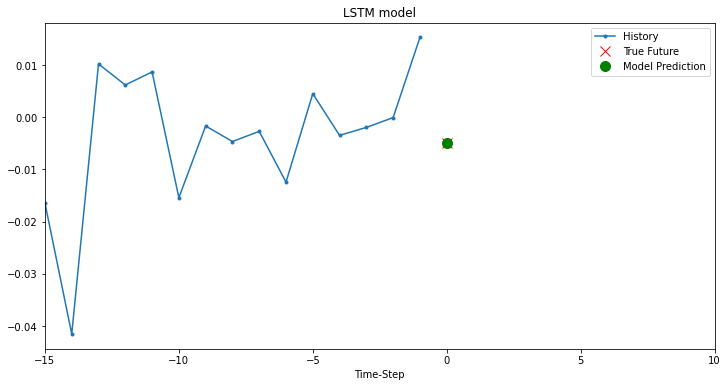

true=-0.02 -- predict=-0.005


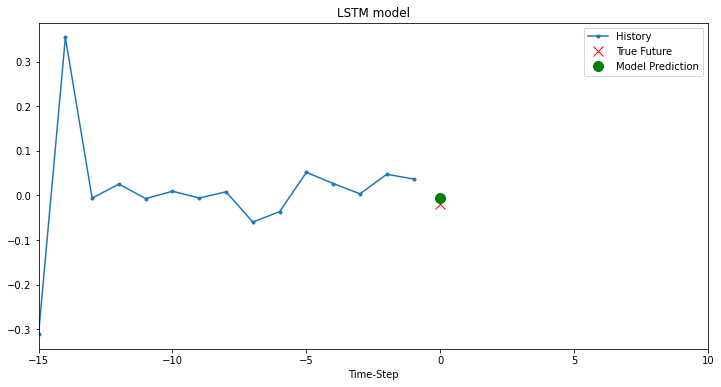

true=-0.04 -- predict=-0.005


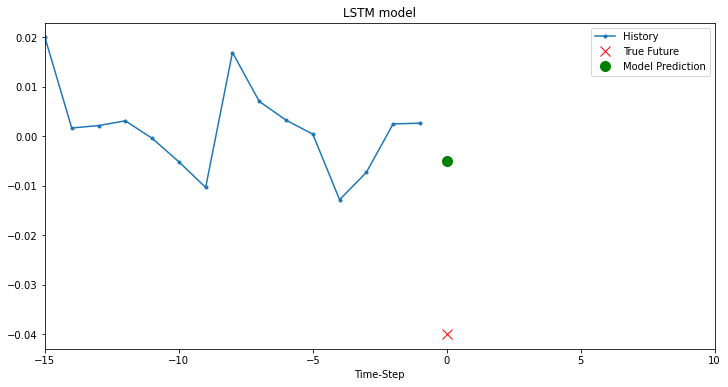

true=-0.16 -- predict=-0.01


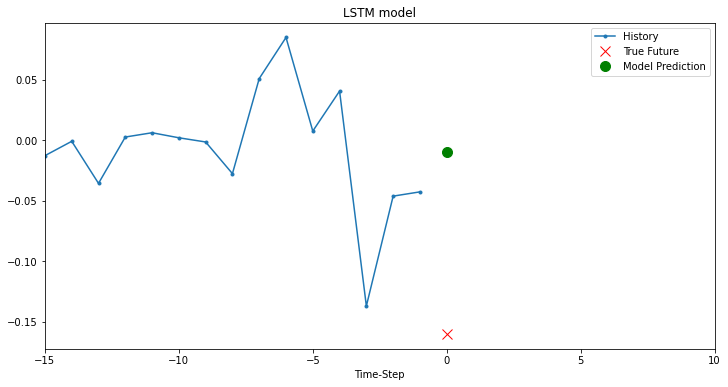

true=0 -- predict=-0.005


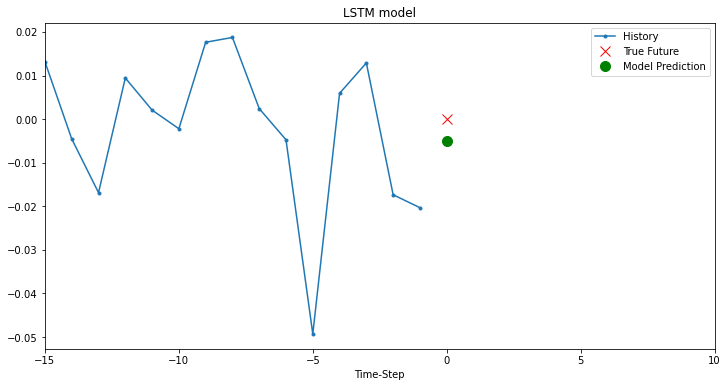

true=-0.02 -- predict=-0.005


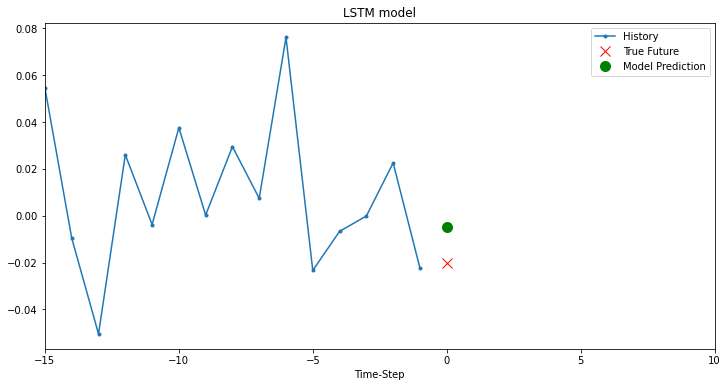

true=-0.02 -- predict=-0.005


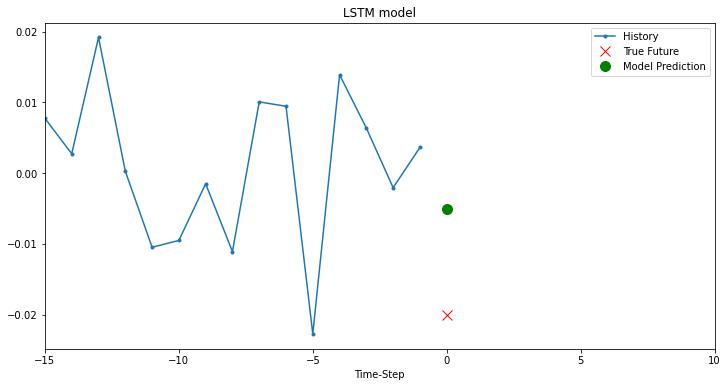

true=-0.005 -- predict=0


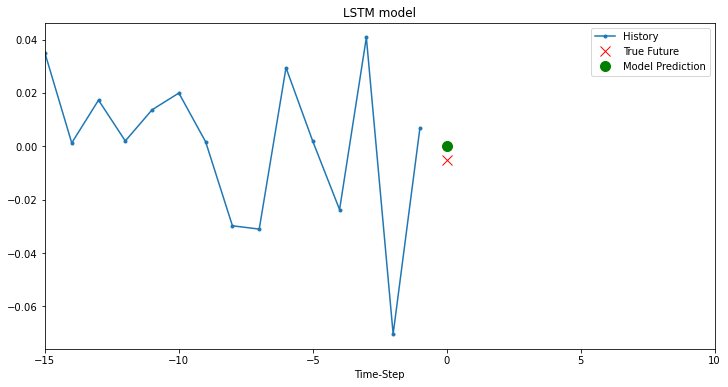

true=-0.01 -- predict=-0.005


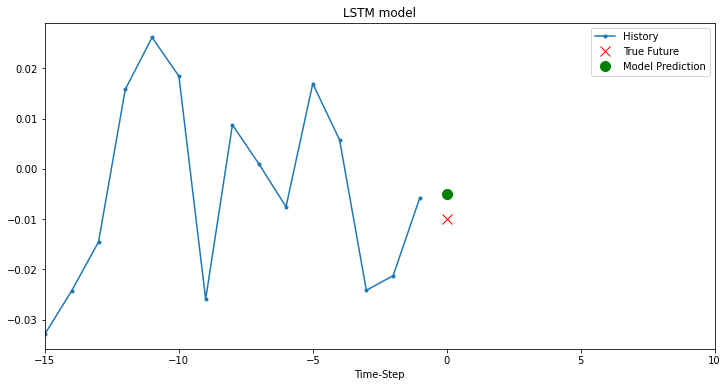

true=-0.01 -- predict=0


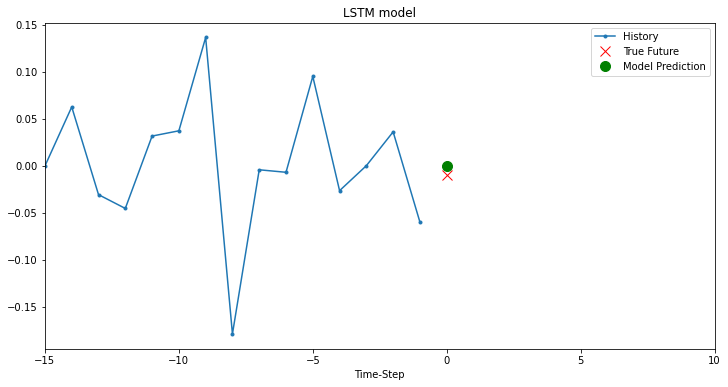

true=0.01 -- predict=0


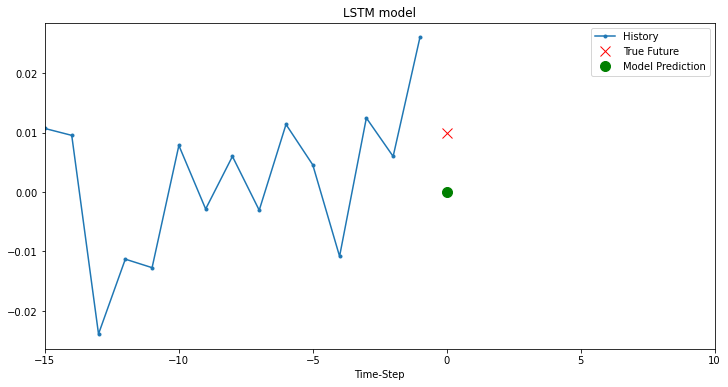

true=0.16 -- predict=0.02


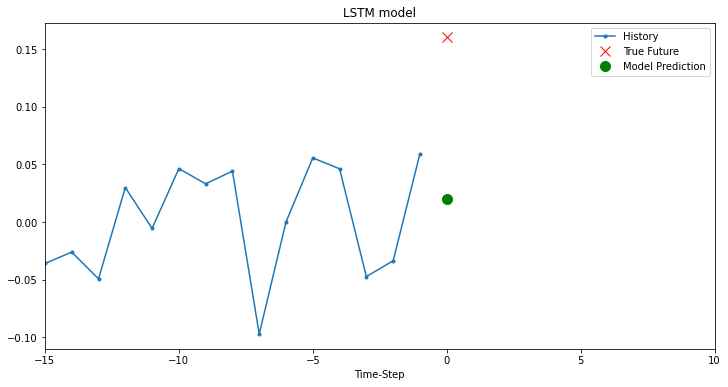

true=-0.04 -- predict=0


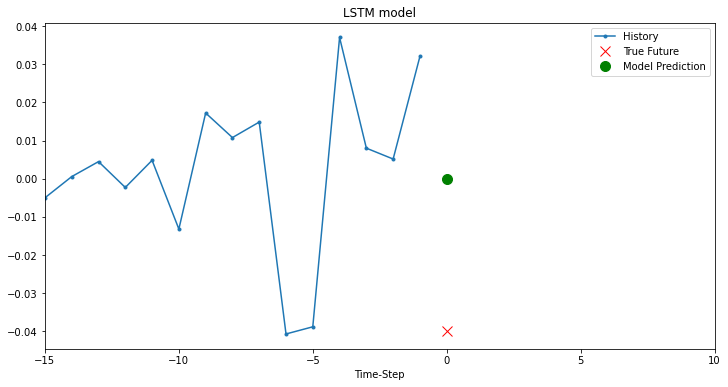

true=0.02 -- predict=0


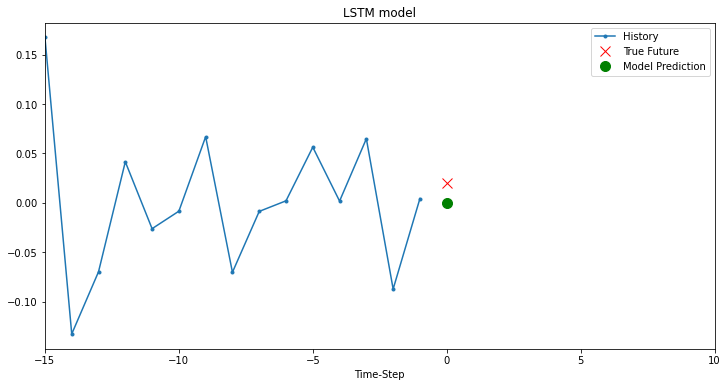

In [118]:
for x, y in val_data_multi.take(100):
    true_future = percentage_from_category(y[0])
    predicted_future = percentage_from_category(multi_step_model.predict(x)[0])
    #arx = pr #tf.math.argmax(pr)
    #print("true=%s -- predict=%s" % (true_future, tf.print(arx))
    tf.print("true=%s -- predict=%s" % (true_future, predicted_future))
    xx = x[0][:, 0].numpy()
#     print(xx)
    plot = show_plot([xx, true_future, predicted_future], 0, 'LSTM model')
    plot.show()

## Next steps
This project was a quick attempt to predict Microsoft stock price movement using an RNN.

We found that predicting next price based on past 60 minutes prices did better than what we expected. Adding more features didnt improve the prediction capability, and we suspect this is because of couple of things we may need to investigate and improve on:

1- Data Normalization: stock price keeps moving up with time, and normalizing it relaitively to the mean of past prices may have not helped. We thing we may need to investigate alternative approach to dataset normalization, ex: moving average.

2- The LSTM model itself: We didnt spend enough time with experimenting with different model architectures. This is something worth exploring.

3- More training data and more model training: We have used only stock data from Jan 2019 up to May 2020, and we only trained for few epochs for the time constraint of yeilding some presentable results for this project. Next step would be to acquire more training data (10 years worth of stock data) and train the model way longer (few days).

4- Tune the model: try smaller learning rate, or a different optimizer, etc.

In [ ]:
a=np.array([[1,2,3],[4, 5, 6]]); b=np.array([10, 10, 10])
np.tensordot(a,b,axes=(1,0)) + 1